<a href="https://colab.research.google.com/github/zeeshanahmad54/H-M-Personalized-Fashion-Recommendations/blob/main/CSCI567_team72_H_and_M_fashion_Item_Similarities_with_prices_fast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and DF Setup

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
!pip install ipython-autotime
%load_ext autotime

time: 168 µs (started: 2022-05-05 14:43:51 +00:00)


In [ ]:
!pip install kaggle
# !pip install sentence_transformers simcse

time: 2.23 s (started: 2022-05-05 14:43:51 +00:00)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 916 ms (started: 2022-05-05 14:43:53 +00:00)


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes
time: 4.57 s (started: 2022-05-05 14:44:35 +00:00)


In [ ]:
import pandas as pd
import numpy as np
# import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering

from sentence_transformers import SentenceTransformer, util
import spacy
import pandas as pd
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
import numpy as np
import heapq


model = SentenceTransformer('stsb-roberta-large', device='cuda')

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)


time: 28.8 s (started: 2022-05-05 14:44:41 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


## Load DFs

In [ ]:
customer_df = pd.read_csv("/content/drive/MyDrive/CSCI_567_ML/Data/customers.csv")

time: 2.97 s (started: 2022-05-05 14:50:53 +00:00)


In [ ]:
article_df = pd.read_csv("/content/drive/MyDrive/CSCI_567_ML/Data/articles.csv")

time: 1.32 s (started: 2022-05-05 09:36:17 +00:00)


In [ ]:
transaction_df = pd.read_csv("/content/drive/MyDrive/CSCI_567_ML/Data/transactions_train.csv")

time: 37.6 s (started: 2022-05-05 09:36:18 +00:00)


In [ ]:
images_folder = "/content/drive/MyDrive/CSCI_567_ML/Data/images"

time: 1.02 ms (started: 2022-05-04 12:55:20 +00:00)


## Customers

In [ ]:
# customer_id : A unique identifier of every customer
# FN : 1 or missed
# Active : 1 or missed
# club_member_status : Status in club
# fashion_news_frequency : How often H&M may send news to customer
# age : The current age
# postal_code : Postal code of customer

time: 1.69 ms (started: 2022-05-04 10:38:05 +00:00)


In [ ]:
customer_df.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a91f8ca0d4b6efa8100
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93f4c830291c32bc3057
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6c9090f7dd3e38380dc
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c222539af5973a23ae6d
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd4564743b005a805b1d


time: 18.1 ms (started: 2022-05-04 10:38:05 +00:00)


In [ ]:
data_postal = customer_df.groupby('postal_code', as_index=False).count().sort_values('customer_id', ascending=False)
data_postal.head()

,postal_code,customer_id,FN,Active,club_member_status,fashion_news_frequency,age
61034,2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c,120303,42874,39886,118281,114377,118002
281937,cc4ed85e30f4977dae47662ddc468cd2eec11472de6fac5ec985080fd92243c8,261,109,104,261,261,260
156090,714976379549eb90aae4a71bca6c7402cc646ae7c40f6c1cb91d4b5a18623fc1,159,90,88,159,159,158
171208,7c1fa3b0ec1d37ce2c3f34f63bd792f3b4494f324b6be5d1e4ba6a75456b96a7,157,55,54,157,156,156
126228,5b7eb31eabebd3277de632b82267286d847fd5d44287ee150bb4206b48439145,156,42,41,156,156,155


time: 1.87 s (started: 2022-05-04 10:38:05 +00:00)


In [ ]:
len(data_postal)

352899

time: 2.96 ms (started: 2022-05-04 10:38:07 +00:00)


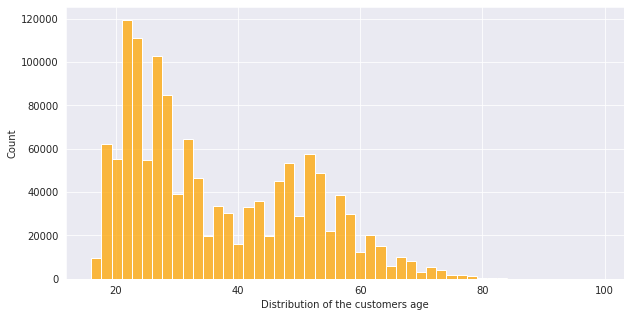

time: 626 ms (started: 2022-05-04 10:38:07 +00:00)


In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=customer_df, x='age', bins=50, color='orange')
ax.set_xlabel('Distribution of the customers age')
plt.show()

## Articles

In [ ]:
# article_id : A unique identifier of every article.
# product_code, prod_name : A unique identifier of every product and its name (not the same).
# product_type, product_type_name : The group of product_code and its name
# graphical_appearance_no, graphical_appearance_name : The group of graphics and its name
# colour_group_code, colour_group_name : The group of color and its name
# perceived_colour_value_id, perceived_colour_value_name, perceived_colour_master_id, perceived_colour_master_name : The added color info
# department_no, department_name: : A unique identifier of every dep and its name
# index_code, index_name: : A unique identifier of every index and its name
# index_group_no, index_group_name: : A group of indeces and its name
# section_no, section_name: : A unique identifier of every section and its name
# garment_group_no, garment_group_name: : A unique identifier of every garment and its name
# detail_desc: : Details

time: 2.85 ms (started: 2022-05-04 10:38:07 +00:00)


In [ ]:
article_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort."


time: 17.6 ms (started: 2022-05-04 10:38:07 +00:00)


### Item (index_name) frequencies


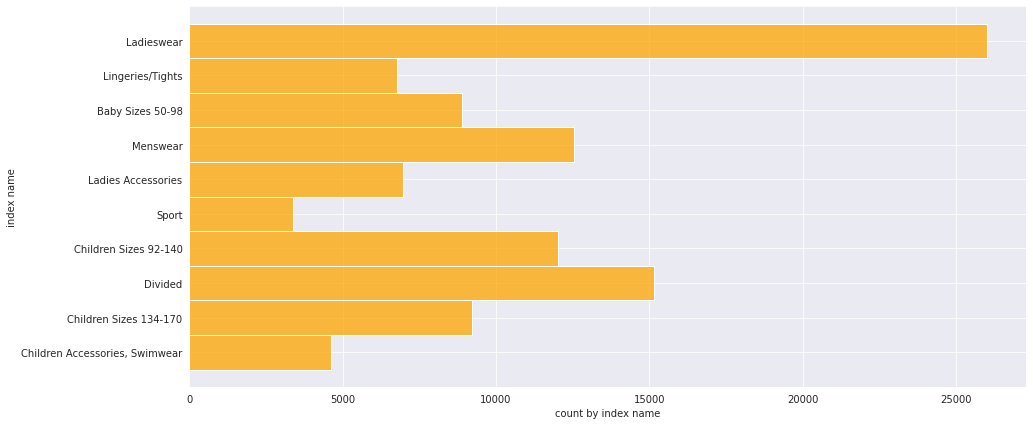

time: 361 ms (started: 2022-05-04 10:38:07 +00:00)


In [ ]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=article_df, y='index_name', color='orange')
ax.set_xlabel('count by index name')
ax.set_ylabel('index name')
plt.show()

### Garment group frequencies

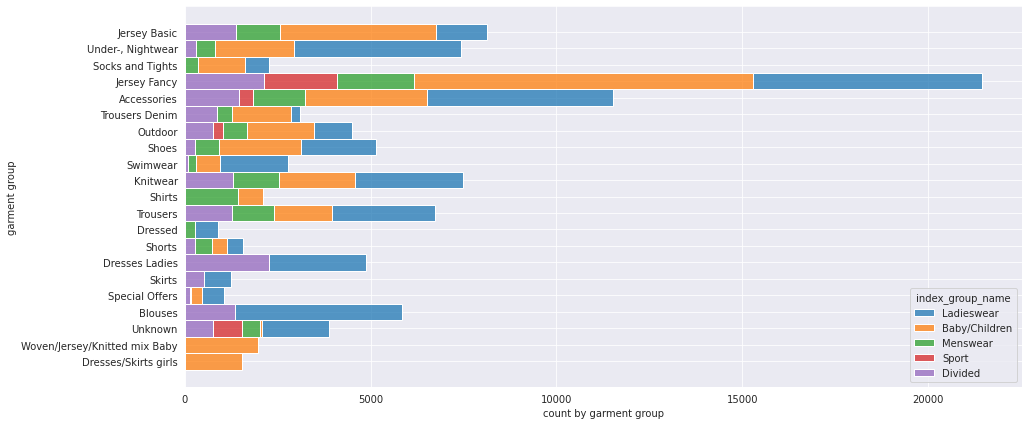

time: 717 ms (started: 2022-05-04 10:38:08 +00:00)


In [ ]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=article_df, y='garment_group_name', color='orange', hue='index_group_name', multiple="stack")
ax.set_xlabel('count by garment group')
ax.set_ylabel('garment group')
plt.show()

In [ ]:
article_df.groupby(['index_group_name', 'index_name']).count()['article_id']


index_group_name  index_name                    
Baby/Children     Baby Sizes 50-98                  8875 
                  Children Accessories, Swimwear    4615 
                  Children Sizes 134-170            9214 
                  Children Sizes 92-140             12007
Divided           Divided                           15149
Ladieswear        Ladies Accessories                6961 
                  Ladieswear                        26001
                  Lingeries/Tights                  6775 
Menswear          Menswear                          12553
Sport             Sport                             3392 
Name: article_id, dtype: int64

time: 107 ms (started: 2022-05-04 10:38:09 +00:00)


### product group-product structure

In [ ]:
pd.options.display.max_rows = None
article_df.groupby(['product_group_name', 'product_type_name']).count()['article_id']

product_group_name     product_type_name       
Accessories            Accessories set             7    
                       Alice band                  6    
                       Baby Bib                    3    
                       Bag                         1280 
                       Beanie                      56   
                       Belt                        458  
                       Bracelet                    180  
                       Braces                      3    
                       Bucket hat                  7    
                       Cap                         13   
                       Cap/peaked                  573  
                       Dog Wear                    20   
                       Earring                     1159 
                       Earrings                    11   
                       Eyeglasses                  2    
                       Felt hat                    10   
                       Giftbox          

time: 114 ms (started: 2022-05-04 10:38:09 +00:00)


In [ ]:
# unique values in columns

for col in article_df.columns:
    if not 'no' in col and not 'code' in col and not 'id' in col:
        un_n = article_df[col].nunique()
        print(f'n of unique {col}: {un_n}')

n of unique prod_name: 45875
n of unique product_type_name: 131
n of unique product_group_name: 19
n of unique graphical_appearance_name: 30
n of unique colour_group_name: 50
n of unique perceived_colour_value_name: 8
n of unique perceived_colour_master_name: 20
n of unique department_name: 250
n of unique index_name: 10
n of unique index_group_name: 5
n of unique section_name: 56
n of unique garment_group_name: 21
n of unique detail_desc: 43404
time: 104 ms (started: 2022-05-04 10:38:09 +00:00)


### Product Similarities

In [ ]:
article_df.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

time: 4.6 ms (started: 2022-05-04 10:38:09 +00:00)


In [ ]:
print(np.sort(article_df['product_type_name'].unique()))

['Accessories set' 'Alice band' 'Baby Bib' 'Backpack' 'Bag' 'Ballerinas'
 'Beanie' 'Belt' 'Bikini top' 'Blanket' 'Blazer' 'Blouse' 'Bodysuit'
 'Bootie' 'Boots' 'Bra' 'Bra extender' 'Bracelet' 'Braces' 'Bucket hat'
 'Bumbag' 'Cap' 'Cap/peaked' 'Cardigan' 'Chem. cosmetics' 'Clothing mist'
 'Coat' 'Costumes' 'Cross-body bag' 'Cushion' 'Dog Wear' 'Dog wear'
 'Dress' 'Dungarees' 'Earring' 'Earrings' 'Eyeglasses' 'Felt hat'
 'Fine cosmetics' 'Flat shoe' 'Flat shoes' 'Flip flop' 'Garment Set'
 'Giftbox' 'Gloves' 'Hair clip' 'Hair string' 'Hair ties'
 'Hair/alice band' 'Hairband' 'Hat/beanie' 'Hat/brim' 'Headband'
 'Heeled sandals' 'Heels' 'Hoodie' 'Jacket' 'Jumpsuit/Playsuit' 'Keychain'
 'Kids Underwear top' 'Leg warmers' 'Leggings/Tights' 'Long John'
 'Marker pen' 'Mobile case' 'Moccasins' 'Necklace' 'Night gown'
 'Nipple covers' 'Other accessories' 'Other shoe' 'Outdoor Waistcoat'
 'Outdoor overall' 'Outdoor trousers' 'Polo shirt' 'Pre-walkers' 'Pumps'
 'Pyjama bottom' 'Pyjama jumpsuit/play

In [ ]:
pd.set_option('display.max_colwidth', -1)


time: 1.12 ms (started: 2022-05-04 10:38:09 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


## Transactions

In [ ]:
# t_dat : A unique identifier of every customer
# customer_id : A unique identifier of every customer (in customers table)
# article_id : A unique identifier of every article (in articles table)
# price : Price of purchase
# sales_channel_id : 1 or 2

time: 743 µs (started: 2022-05-04 10:38:09 +00:00)


In [ ]:
transaction_df.loc[transaction_df['customer_id'] == customer_df.iloc[0]['customer_id']]
# transaction_df[transaction_df['customer_id'].str.contains("000058a12d5b43e67d225668fa1f8d618c13dc232df0ca")]

,t_dat,customer_id,article_id,price,sales_channel_id
4212358,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,625548001,0.044051,1
4212359,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,176209023,0.035576,1
4212360,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,627759010,0.030492,1
9663224,2019-05-02,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,697138006,0.010153,2
10754876,2019-05-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,568601006,0.050831,2
10754877,2019-05-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,568601006,0.050831,2
14479578,2019-07-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,607642008,0.012695,1
14479579,2019-07-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,745232001,0.021169,1
16728347,2019-09-18,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,656719005,0.044051,2
17074660,2019-09-28,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,797065001,0.054220,2


time: 1.83 s (started: 2022-05-04 10:38:09 +00:00)


In [ ]:
print(len(transaction_df))

31788324
time: 1.24 ms (started: 2022-05-04 10:38:11 +00:00)


In [ ]:
pairs = np.load('/content/drive/MyDrive/CSCI_567_ML/Data/pairs_cudf.npy',allow_pickle=True).item()

time: 1.16 s (started: 2022-05-04 10:38:11 +00:00)


In [ ]:
print(list(pairs.items())[0])

(706016001, 706016002)
time: 8.36 ms (started: 2022-05-04 10:38:12 +00:00)


## Get last month transactions and join with articles and customers

In [ ]:
article_sim_df = pd.read_csv("/content/drive/MyDrive/CSCI_567_ML/Data/articles_with_top12_similar_images.csv")

time: 2.18 s (started: 2022-05-05 07:21:28 +00:00)


In [ ]:
print(len(article_sim_df))

105542
time: 2.25 ms (started: 2022-05-05 07:21:31 +00:00)


In [ ]:
for col in article_sim_df.columns:
  print(col)

Unnamed: 0
article_id
product_code
prod_name
product_type_no
product_type_name
product_group_name
graphical_appearance_no
graphical_appearance_name
colour_group_code
colour_group_name
perceived_colour_value_id
perceived_colour_value_name
perceived_colour_master_id
perceived_colour_master_name
department_no
department_name
index_code
index_name
index_group_no
index_group_name
section_no
section_name
garment_group_no
garment_group_name
detail_desc
sim_1_prod
sim_2_prod
sim_3_prod
sim_4_prod
sim_5_prod
sim_6_prod
sim_7_prod
sim_8_prod
sim_9_prod
sim_10_prod
sim_11_prod
sim_12_prod
time: 4.4 ms (started: 2022-05-05 07:21:31 +00:00)


In [ ]:
for col in transaction_df.columns:
  print(col)

t_dat
customer_id
article_id
price
sales_channel_id
time: 1.72 ms (started: 2022-05-05 07:21:31 +00:00)


In [ ]:
# pd.set_option('display.float_format', '{:.4f}'.format)
# transaction_df.describe()['price']

In [ ]:
articles_for_merge = article_sim_df[['article_id', 'prod_name', 'product_type_name', 'product_group_name', 'index_name', 'colour_group_name', 'detail_desc', 'sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod', 'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod', 'sim_10_prod', 'sim_11_prod', 'sim_12_prod']]

time: 38.4 ms (started: 2022-05-05 07:21:31 +00:00)


In [ ]:
# Last month transactions

transaction_df['t_dat'] = pd.to_datetime(transaction_df['t_dat'])
last_ts = transaction_df['t_dat'].max()
print("last_ts", last_ts)
mask = (transaction_df['t_dat'] > '2020-08-22') & (transaction_df['t_dat'] <= '2020-09-22')
last_month_transactions = transaction_df.loc[mask]

last_ts 2020-09-22 00:00:00
time: 4.37 s (started: 2022-05-05 07:21:31 +00:00)


In [ ]:
print(len(last_month_transactions))

1155933
time: 1.28 ms (started: 2022-05-05 07:21:35 +00:00)


In [ ]:
articles_for_merge = last_month_transactions[['customer_id', 'article_id', 'price', 't_dat']].merge(articles_for_merge, on='article_id', how='left')

time: 450 ms (started: 2022-05-05 07:21:35 +00:00)


In [ ]:
# articles_for_merge = customer_df[['customer_id', 'age', 'postal_code']].merge(articles_for_merge, on='customer_id', how='left')
articles_for_merge = articles_for_merge.merge(customer_df[['customer_id', 'age', 'postal_code']], on='customer_id', how='left')

time: 1.51 s (started: 2022-05-05 07:21:36 +00:00)


In [ ]:
# articles_for_merge = articles_for_merge.merge(article_df_new, on='article_id', how='outer')

time: 725 µs (started: 2022-05-04 10:42:38 +00:00)


In [ ]:
articles_for_merge.head()

,customer_id,article_id,price,t_dat,prod_name,product_type_name,product_group_name,index_name,colour_group_name,detail_desc,sim_1_prod,sim_2_prod,sim_3_prod,sim_4_prod,sim_5_prod,sim_6_prod,sim_7_prod,sim_8_prod,sim_9_prod,sim_10_prod,sim_11_prod,sim_12_prod,age,postal_code
0,001cb0cd244c58fa35f9eb21f995b9e2f3e0c67c4e89af841df9f3d9adbe3893,464297031,0.016932,2020-08-23,Greta Thong Mynta Low 3p,Underwear bottom,Underwear,Lingeries/Tights,Dark Grey,"Thong briefs in cotton jersey with a wide lace trim at the top. Low waist, lined gusset, narrow sides and a string back.",703207001.0,693499001.0,614854007.0,613913001.0,826955008.0,579302005.0,736780002.0,866455003.0,889974002.0,793949001.0,699361001.0,656032005.0,18.0,2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c
1,003a8444fce07c006258eb969943a4f1ff14c696af8c1f0e73964fe082672d4e,797988001,0.025407,2020-08-23,Furby Roll Neck,Top,Garment Upper body,Divided,White,Fitted jumper in a soft rib knit with a foldover polo neck and long sleeves.,766139003.0,758226001.0,707307001.0,906258001.0,865926001.0,797118001.0,825580002.0,877222005.0,923340002.0,716099001.0,663699003.0,615805003.0,23.0,72aa0cb8f3b9f28372ff822c098a981163898cd3245314b84160c056cabff6f9
2,003a8444fce07c006258eb969943a4f1ff14c696af8c1f0e73964fe082672d4e,832307003,0.038119,2020-08-23,Notre Dame(1),Blazer,Garment Upper body,Ladieswear,Black,"Straight-cut, double-breasted jacket in woven fabric with notch lapels, pearly buttons at the front, flap front pockets and a gently tapered waist. Lined.",831439001.0,781078003.0,827635001.0,920610001.0,895991001.0,707051001.0,813113002.0,820168001.0,607564006.0,854301002.0,568601038.0,925404001.0,23.0,72aa0cb8f3b9f28372ff822c098a981163898cd3245314b84160c056cabff6f9
3,003e750f71b6b1a81b561d50b7c76620c8c1f6b6a91981ba685c5140fb628152,761696004,0.042356,2020-08-23,Twain Sl-set (W),Pyjama set,Nightwear,Lingeries/Tights,Black,Pyjamas with a shirt and shorts in satin with piped trims. Shirt with rounded notch lapels and buttons down the front. Shorts with covered elastication at the waist.,655792014.0,655792016.0,790132002.0,715114001.0,909923001.0,598604003.0,713380002.0,485548022.0,528283001.0,924606002.0,742457001.0,918171001.0,26.0,bbab2c851d6f7ccea35735cc8dc16d8aa6002002512590090543c36e292cf1a0
4,0050be3089108d675eaa2e173b9a045a33ee7c25acfafc46657e8f672d655402,743633001,0.050831,2020-08-23,Straight H.W Ankle Mies,Trousers,Garment Lower body,Divided,Light Blue,"5-pocket ankle-length jeans in washed denim with worn details, a high waist, button fly and straight legs.",900170001.0,900169002.0,720861003.0,743633005.0,687704022.0,714790033.0,750330004.0,690449007.0,920972001.0,673835001.0,812207003.0,900170002.0,58.0,ef1fc30d85803760f9ff3517b5dd78900360a777148ea43f9c438bdfcec6617b


time: 67.1 ms (started: 2022-05-05 07:21:37 +00:00)


In [ ]:
print(len(articles_for_merge))

1155933
time: 1.37 ms (started: 2022-05-05 07:21:37 +00:00)


## Explore Trending

In [ ]:
import gc
import pandas as pd

del [[article_sim_df,transaction_df]]
gc.collect()
article_sim_df=pd.DataFrame()
transaction_df=pd.DataFrame()

time: 734 ms (started: 2022-05-05 01:51:56 +00:00)


In [ ]:
import pandas as pd
import numpy as np
from math import sqrt
from pathlib import Path
from tqdm import tqdm
tqdm.pandas()

N = 12

time: 7.03 ms (started: 2022-05-05 01:51:57 +00:00)


In [ ]:
# # Last month transactions

# transaction_df['t_dat'] = pd.to_datetime(transaction_df['t_dat'])
# last_ts = transaction_df['t_dat'].max()
# print("last_ts", last_ts)
# mask = (transaction_df['t_dat'] > '2020-08-22') & (transaction_df['t_dat'] <= '2020-09-22')
# last_month_transactions = transaction_df.loc[mask]

In [ ]:
# df_trans = pd.read_csv('/kaggle/input/h-and-m-personalized-fashion-recommendations/transactions_train.csv',dtype={'article_id': str})
# df_trans = pd.read_csv("/content/drive/MyDrive/CSCI_567_ML/Data/transactions_train.csv",dtype={'article_id': str})

time: 35.2 s (started: 2022-05-04 10:28:25 +00:00)


In [ ]:
df = articles_for_merge

time: 4.79 ms (started: 2022-05-05 01:51:57 +00:00)


In [ ]:
# df['t_dat'] = pd.to_datetime(df['t_dat'])

time: 14.4 ms (started: 2022-05-04 22:48:38 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
print(len(articles_for_merge))
print(len(df))

1155933
1155933
time: 6.01 ms (started: 2022-05-05 01:51:57 +00:00)


In [ ]:
for col in articles_for_merge.columns:
  print(col)

customer_id
article_id
price
t_dat
prod_name
product_type_name
product_group_name
index_name
colour_group_name
detail_desc
sim_1_prod
sim_2_prod
sim_3_prod
sim_4_prod
sim_5_prod
sim_6_prod
sim_7_prod
sim_8_prod
sim_9_prod
sim_10_prod
sim_11_prod
sim_12_prod
age
postal_code
time: 5.93 ms (started: 2022-05-05 01:51:57 +00:00)


In [ ]:
# # Step1
# # ldbw = last day of billing week

# # df = df_trans[['t_dat', 'customer_id', 'article_id']].copy()
# # df = df_trans.copy()
# last_ts = df['t_dat'].max()
# print("last_ts", last_ts)
# df['ldbw'] = df['t_dat'].progress_apply(lambda d: last_ts - (last_ts - d).floor('7D')) #~50 mins to exec this line
# weekly_sales = df.drop('customer_id', axis=1).groupby(['ldbw', 'article_id']).count()
# weekly_sales = weekly_sales.rename(columns={'t_dat': 'count'})
# df = df.join(weekly_sales, on=['ldbw', 'article_id'])
# weekly_sales = weekly_sales.reset_index().set_index('article_id')
# last_day = last_ts.strftime('%Y-%m-%d')

# df = df.join(
#     weekly_sales.loc[weekly_sales['ldbw']==last_day, ['count']],
#     on='article_id', rsuffix="_targ")

# df['count_targ'].fillna(0, inplace=True)
# del weekly_sales
# df['quotient'] = df['count_targ'] / df['count']



# Try trending with 2 weeks
# ldbw = last day of billing week

# df = df_trans[['t_dat', 'customer_id', 'article_id']].copy()
# df = df_trans.copy()
last_ts = df['t_dat'].max()
print("last_ts", last_ts)
df['ldbw'] = df['t_dat'].progress_apply(lambda d: last_ts - (last_ts - d).floor('7D')) #~50 mins to exec this line
weekly_sales = df.drop(['customer_id', 'prod_name', 'product_type_name', 'product_group_name', 'index_name', 'colour_group_name', 'detail_desc', 'sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod', 'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod', 'sim_10_prod', 'sim_11_prod', 'sim_12_prod', 'price', 'age', 'postal_code'], axis=1).groupby(['ldbw', 'article_id']).count()
print("\n")
print(weekly_sales.head())
weekly_sales = weekly_sales.rename(columns={'t_dat': 'count'})
print(weekly_sales.head())
df = df.join(weekly_sales, on=['ldbw', 'article_id'])
print(df.head())
weekly_sales = weekly_sales.reset_index().set_index('article_id')
last_day = last_ts.strftime('%Y-%m-%d')

df = df.join(
    weekly_sales.loc[weekly_sales['ldbw']==last_day, ['count']],
    on='article_id', rsuffix="_targ")

df['count_targ'].fillna(0, inplace=True)
del weekly_sales
gc.collect()
weekly_sales=pd.DataFrame()

df['quotient'] = df['count_targ'] / df['count']




last_ts 2020-09-22 00:00:00


100%|██████████| 1155933/1155933 [02:31<00:00, 7620.66it/s]




                       t_dat
ldbw       article_id       
2020-08-25 108775044   1    
           110065011   1    
           111565001   8    
           111586001   23   
           111593001   16   
                       count
ldbw       article_id       
2020-08-25 108775044   1    
           110065011   1    
           111565001   8    
           111586001   23   
           111593001   16   
                                                        customer_id  \
0  001cb0cd244c58fa35f9eb21f995b9e2f3e0c67c4e89af841df9f3d9adbe3893   
1  003a8444fce07c006258eb969943a4f1ff14c696af8c1f0e73964fe082672d4e   
2  003a8444fce07c006258eb969943a4f1ff14c696af8c1f0e73964fe082672d4e   
3  003e750f71b6b1a81b561d50b7c76620c8c1f6b6a91981ba685c5140fb628152   
4  0050be3089108d675eaa2e173b9a045a33ee7c25acfafc46657e8f672d655402   

   article_id     price      t_dat                 prod_name  \
0  464297031   0.016932 2020-08-23  Greta Thong Mynta Low 3p   
1  797988001   0.025407 2020-08-23  F

In [ ]:
print(len(df))

1155933
time: 5.34 ms (started: 2022-05-05 01:54:30 +00:00)


In [ ]:
df.to_csv("/content/drive/MyDrive/CSCI_567_ML/Data/last_month_trans.csv")

time: 53.3 s (started: 2022-05-04 23:37:55 +00:00)


In [ ]:
# purchase_dict = {}
# #~35 mins for the loop
# for i in tqdm(df.index):
#     cust_id = df.at[i, 'customer_id']
#     art_id = df.at[i, 'article_id']
#     t_dat = df.at[i, 't_dat']

#     if cust_id not in purchase_dict:
#         purchase_dict[cust_id] = {}

#     if art_id not in purchase_dict[cust_id]:
#         purchase_dict[cust_id][art_id] = 0
    
#     x = max(1, (last_ts - t_dat).days)

#     a, b, c, d = 2.5e4, 1.5e5, 2e-1, 1e3
#     y = a / np.sqrt(x) + b * np.exp(-c*x) - d

#     value = df.at[i, 'quotient'] * max(0, y)
#     purchase_dict[cust_id][art_id] += value

# target_sales = df.drop('customer_id', axis=1).groupby('article_id')['quotient'].sum()
# general_pred = target_sales.nlargest(N).index.tolist()


purchase_dict = {}
#~35 mins for the loop
for i in tqdm(df.index):
    cust_id = df.at[i, 'customer_id']
    art_id = df.at[i, 'article_id']
    t_dat = df.at[i, 't_dat']

    if cust_id not in purchase_dict:
        purchase_dict[cust_id] = {}

    if art_id not in purchase_dict[cust_id]:
        purchase_dict[cust_id][art_id] = 0
    
    x = max(1, (last_ts - t_dat).days)

    a, b, c, d = 2.5e4, 1.5e5, 2e-1, 1e3
    y = a / np.sqrt(x) + b * np.exp(-c*x) - d

    value = df.at[i, 'quotient'] * max(0, y)
    purchase_dict[cust_id][art_id] += value

target_sales = df.drop('customer_id', axis=1).groupby('article_id')['quotient'].sum()
general_pred = target_sales.nlargest(N).index.tolist()

100%|██████████| 10/10 [00:00<00:00, 2511.26it/s]

time: 46.4 ms (started: 2022-05-04 22:49:54 +00:00)


In [ ]:
# Try trending with 2 weeks
# ldbw = last day of billing week

# df = df_trans[['t_dat', 'customer_id', 'article_id']].copy()
# df = df_trans.copy()
last_ts = df['t_dat'].max()
print("last_ts", last_ts)
df['15d_ldbw'] = df['t_dat'].progress_apply(lambda d: last_ts - (last_ts - d).floor('15D')) #~50 mins to exec this line
weekly_sales = df.drop(['customer_id', 'prod_name', 'product_type_name', 'product_group_name', 'index_name', 'colour_group_name', 'detail_desc', 'sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod', 'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod', 'sim_10_prod', 'sim_11_prod', 'sim_12_prod', 'price'], axis=1).groupby(['15d_ldbw', 'article_id']).count()
print("\n")
print(weekly_sales.head())
weekly_sales = weekly_sales.rename(columns={'t_dat': 'count'})
print(weekly_sales.head())
df = df.join(weekly_sales, on=['15d_ldbw', 'article_id'])
print(df.head())
weekly_sales = weekly_sales.reset_index().set_index('article_id')
last_day = last_ts.strftime('%Y-%m-%d')

df = df.join(
    weekly_sales.loc[weekly_sales['15d_ldbw']==last_day, ['count']],
    on='article_id', rsuffix="_targ")

df['count_targ'].fillna(0, inplace=True)
del weekly_sales
df['quotient'] = df['count_targ'] / df['count']



In [ ]:
df.to_csv("/content/drive/MyDrive/CSCI_567_ML/Data/trending_15D.csv")

In [ ]:
purchase_dict = {}
#~35 mins for the loop
for i in tqdm(df.index):
    cust_id = df.at[i, 'customer_id']
    art_id = df.at[i, 'article_id']
    t_dat = df.at[i, 't_dat']

    if cust_id not in purchase_dict:
        purchase_dict[cust_id] = {}

    if art_id not in purchase_dict[cust_id]:
        purchase_dict[cust_id][art_id] = 0
    
    x = max(1, (last_ts - t_dat).days)

    a, b, c, d = 2.5e4, 1.5e5, 2e-1, 1e3
    y = a / np.sqrt(x) + b * np.exp(-c*x) - d

    value = df.at[i, 'quotient'] * max(0, y)
    purchase_dict[cust_id][art_id] += value

target_sales = df.drop('customer_id', axis=1).groupby('article_id')['quotient'].sum()
general_pred = target_sales.nlargest(N).index.tolist()

100%|██████████| 10/10 [00:00<00:00, 6719.49it/s]

time: 29 ms (started: 2022-05-04 22:50:07 +00:00)


In [ ]:
customer_list = list(purchase_dict.keys())
# for i in purchase_dict.keys():
#   customer_list.extend(i)

time: 1.67 ms (started: 2022-05-04 22:50:09 +00:00)


In [ ]:
len(customer_list)

NameError: ignored

time: 64.2 ms (started: 2022-05-05 01:50:01 +00:00)


In [ ]:
print(general_pred)

[501323011, 505221001, 505221004, 541518023, 598859003, 663713001, 685687001, 685687003, 685687004, 688873012]
time: 1.46 ms (started: 2022-05-04 22:50:12 +00:00)


In [ ]:
# Step2 & Step3

pairs = np.load('/content/drive/MyDrive/CSCI_567_ML/Data/pairs_cudf.npy',allow_pickle=True).item()
sub = pd.read_csv('/content/drive/MyDrive/CSCI_567_ML/Data/sample_submission.csv')

# sim_prods = df[['sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod', 'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod', 'sim_10_prod', 'sim_11_prod', 'sim_12_prod']].values[df["article_id"] == int(elm)][0].tolist()
# sim_prods = [int(x) for x in sim_prods]
# sim_prods

# ~15 mins
pred_list = []
for cust_id in tqdm(sub['customer_id']):
    if cust_id in purchase_dict:
        series = pd.Series(purchase_dict[cust_id])
        series = series[series > 150]
        l = series.nlargest(N).index.tolist()
        tmp_l = l.copy()
        for elm in tmp_l:

            # if len(l) < N and int(elm) in pairs.keys():
            # print(f"article_id = {elm}")
            # articles_for_merge
            
            if len(l) < N and int(elm) in list(df['article_id']):
                sim_prods = df[['sim_1_prod']].values[df["article_id"] == int(elm)][0].tolist()
                # print(sim_prods)
                sim_prods = [int(x) for x in sim_prods if str(x) != "nan"]
                # print(sim_prods)

                if len(sim_prods) == 0:
                  # print("nan")
                  #for this particular element, add a general prediction
                  if int(elm) in pairs.keys():
                    itm = pairs[int(elm)]
                    l.append(str(itm))
                    # print("added from general pred")
                else:
                  # print(f"sim prof of {elm} = {sim_prods[0]}")
                  itm = sim_prods[0]
                  l.append(str(itm))
                  # print("added from sim mat")
        if len(l) < N:            
            l = l + general_pred[:(N-len(l))]
            # print("added from general pred")
    else:
        l = general_pred
    # print(l)
    l = ['0'+str(x) for x in l]
    pred_list.append(' '.join(l))

# sub['prediction'] = pred_list

100%|██████████| 1371980/1371980 [00:06<00:00, 210426.48it/s]

time: 12.1 s (started: 2022-05-04 22:50:20 +00:00)


In [ ]:
sub['prediction'] = pred_list

In [ ]:
for i in pred_list:
  print(i.split(" "))

In [ ]:
# Step2 & Step3

pairs = np.load('/content/pairs_cudf.npy',allow_pickle=True).item()
sub = pd.read_csv('/content/drive/MyDrive/CSCI_567_ML/Data/sample_submission.csv')

# ~15 mins
pred_list = []
for cust_id in tqdm(sub['customer_id']):
    if cust_id in purchase_dict:
        series = pd.Series(purchase_dict[cust_id])
        series = series[series > 150]
        l = series.nlargest(N).index.tolist()
        tmp_l = l.copy()
        for elm in tmp_l:
            if len(l) < N and int(elm) in pairs.keys():
                itm = pairs[int(elm)]
                l.append('0' + str(itm))
        if len(l) < N:
            l = l + general_pred[:(N-len(l))]
    else:
        l = general_pred
    pred_list.append(' '.join(l))

sub['prediction'] = pred_list

100%|██████████| 1371980/1371980 [14:17<00:00, 1599.56it/s]


time: 14min 24s (started: 2022-05-01 12:25:31 +00:00)


In [ ]:
sub.to_csv('/content/drive/MyDrive/CSCI_567_ML/sub_with_sim.csv')

time: 8.11 s (started: 2022-05-01 12:39:57 +00:00)


In [ ]:
sub.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0568601006 0568601006 0568597006 04...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0826211002 0800436010 0739590027 0706016001 06...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0852643001 0852643003 0858883002 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0448509014 0573085028 0751471001 0706016001 06...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0730683050 0791587015 0896152002 0818320001 09...


time: 10.9 ms (started: 2022-05-01 12:40:16 +00:00)


In [ ]:
#1. Get last month transactions
#2. Merge with customer age, postal, article data
#3. Cluster using customer age
#4. Create trending predictions per age bucket


In [ ]:
# loaded_7d = pd.read_csv("/content/drive/MyDrive/CSCI_567_ML/Data/DF_7D.csv")
loaded_7d = pd.read_csv("/content/drive/MyDrive/CSCI_567_ML/Data/DF_7D.csv",header = "infer", skiprows=0, nrows=1000)
# df = pd.read_csv('matrix.txt',sep=',', header = "infer", skiprows= 1000, nrows=1000)


time: 21 ms (started: 2022-05-04 23:18:17 +00:00)


In [ ]:
loaded_7d.head()

,Unnamed: 0,customer_id,article_id,price,t_dat,prod_name,product_type_name,product_group_name,index_name,colour_group_name,detail_desc,sim_1_prod,sim_2_prod,sim_3_prod,sim_4_prod,sim_5_prod,sim_6_prod,sim_7_prod,sim_8_prod,sim_9_prod,sim_10_prod,sim_11_prod,sim_12_prod,ldbw,count,count_targ,quotient
0,0,000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,663713001,0.050831,2018-09-20,Atlanta Push Body Harlow,Underwear body,Underwear,Lingeries/Tights,Black,"Lace push-up body with underwired, moulded, padded cups for a larger bust and fuller cleavage. Narrow, adjustable shoulder straps, an opening with a hook-and-eye fastening at the back and a lined gusset with concealed press-studs.",667641001.0,874620001.0,804666001.0,703416001.0,809487001.0,622031002.0,783830001.0,650040001.0,650037001.0,813613001.0,812428001.0,802529001.0,2018-09-25,40,0.0,0.0
1,1,000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,541518023,0.030492,2018-09-20,Rae Push (Melbourne) 2p,Bra,Underwear,Lingeries/Tights,Light Pink,"Lace push-up bras with underwired, moulded, padded cups for a larger bust and fuller cleavage. Adjustable shoulder straps and a narrow fastening at the back with two pairs of hooks and eyes.",699253004.0,610926002.0,351933041.0,569594001.0,492853004.0,560389011.0,325087044.0,633142004.0,647822002.0,820572005.0,481110019.0,639525002.0,2018-09-25,29,0.0,0.0
2,2,00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,505221004,0.015237,2018-09-20,Inca Jumper,Sweater,Garment Upper body,Divided,Pink,"Jumper in rib-knit cotton with hard-worn details, a wide, roll-edge neckline, and gently dropped shoulders.",642155001.0,693243009.0,677956001.0,788237001.0,522374002.0,832819001.0,564358036.0,678942047.0,845427009.0,870518010.0,844932002.0,801123004.0,2018-09-25,15,0.0,0.0
3,3,00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,685687003,0.016932,2018-09-20,W YODA KNIT OL OFFER,Sweater,Garment Upper body,Ladieswear,Pink,"V-neck knitted jumper with long sleeves and ribbing around the neckline, cuffs and hem.",708531002.0,568864003.0,636935002.0,675581008.0,690222004.0,782758002.0,636935010.0,516903015.0,725216004.0,794797003.0,543054019.0,636389002.0,2018-09-25,1184,0.0,0.0
4,4,00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,685687004,0.016932,2018-09-20,W YODA KNIT OL OFFER,Sweater,Garment Upper body,Ladieswear,Dark Green,"V-neck knitted jumper with long sleeves and ribbing around the neckline, cuffs and hem.",676090001.0,911870005.0,903276001.0,674448003.0,893350002.0,825688002.0,532578028.0,696996005.0,592172007.0,762619003.0,519712006.0,906100001.0,2018-09-25,1094,0.0,0.0


time: 32.7 ms (started: 2022-05-04 23:18:19 +00:00)


In [ ]:
for cols in loaded_7d.columns:
  print(cols)

Unnamed: 0
customer_id
article_id
price
t_dat
prod_name
product_type_name
product_group_name
index_name
colour_group_name
detail_desc
sim_1_prod
sim_2_prod
sim_3_prod
sim_4_prod
sim_5_prod
sim_6_prod
sim_7_prod
sim_8_prod
sim_9_prod
sim_10_prod
sim_11_prod
sim_12_prod
ldbw
count
count_targ
quotient
time: 3.24 ms (started: 2022-05-04 23:18:25 +00:00)


In [ ]:
print(f'memory usage of dfTransactions : {dfTransactions.memory_usage(index=True).sum() / 1024 ** 2} KB \n')
dfTransactions['price'] = dfTransactions['price'].astype('float32')
print(f'memory usage of dfTransactions after change dtype: {dfTransactions.memory_usage(index=True).sum() / 1024 ** 2} KB \n')

## Faster Trending

### Setup CuDF

In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

In [ ]:
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

In [ ]:
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:23
🔁 Restarting kernel...


In [ ]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

In [ ]:
import numpy as np
import pandas as pd 
from datetime import datetime, timedelta
import gc

import cudf

time: 3.61 s (started: 2022-05-05 14:45:10 +00:00)


In [ ]:
N = 12

time: 1.19 ms (started: 2022-05-05 14:45:13 +00:00)


## Build General Pred

In [ ]:
N = 12

time: 716 µs (started: 2022-05-05 14:45:13 +00:00)


In [ ]:
df  = cudf.read_csv("/content/drive/MyDrive/CSCI_567_ML/Data/transactions_train.csv",
                            usecols= ['t_dat', 'customer_id', 'article_id'], 
                            dtype={'article_id': 'int32', 't_dat': 'string', 'customer_id': 'string'})
# df_trans = pd.read_csv("/content/drive/MyDrive/CSCI_567_ML/Data/transactions_train.csv",dtype={'article_id': str})

df ['customer_id'] = df ['customer_id'].str[-16:].str.hex_to_int().astype('int64')

df['t_dat'] = cudf.to_datetime(df['t_dat'])
last_ts = df['t_dat'].max()

time: 24.9 s (started: 2022-05-05 14:45:15 +00:00)


In [ ]:
%%time
tmp = df[['t_dat']].copy().to_pandas()
tmp['dow'] = tmp['t_dat'].dt.dayofweek
tmp['ldbw'] = tmp['t_dat'] - pd.TimedeltaIndex(tmp['dow'] - 1, unit='D')
tmp.loc[tmp['dow'] >=2 , 'ldbw'] = tmp.loc[tmp['dow'] >=2 , 'ldbw'] + pd.TimedeltaIndex(np.ones(len(tmp.loc[tmp['dow'] >=2])) * 7, unit='D')

df['ldbw'] = tmp['ldbw'].values

CPU times: user 6.78 s, sys: 597 ms, total: 7.38 s
Wall time: 7.24 s
time: 7.25 s (started: 2022-05-05 14:45:40 +00:00)


In [ ]:
weekly_sales = df.drop('customer_id', axis=1).groupby(['ldbw', 'article_id']).count().reset_index()
weekly_sales = weekly_sales.rename(columns={'t_dat': 'count'})

time: 89.7 ms (started: 2022-05-05 14:45:47 +00:00)


In [ ]:
df = df.merge(weekly_sales, on=['ldbw', 'article_id'], how = 'left')

time: 112 ms (started: 2022-05-05 14:45:48 +00:00)


In [ ]:
weekly_sales = weekly_sales.reset_index().set_index('article_id')

df = df.merge(
    weekly_sales.loc[weekly_sales['ldbw']==last_ts, ['count']],
    on='article_id', suffixes=("", "_targ"))

df['count_targ'].fillna(0, inplace=True)
del weekly_sales

time: 86.2 ms (started: 2022-05-05 14:45:48 +00:00)


In [ ]:
df['quotient'] = df['count_targ'] / df['count']

time: 10.5 ms (started: 2022-05-05 14:45:48 +00:00)


In [ ]:
target_sales = df.drop('customer_id', axis=1).groupby('article_id')['quotient'].sum()
general_pred = target_sales.nlargest(N).index.to_pandas().tolist()
general_pred = ['0' + str(article_id) for article_id in general_pred]
general_pred_str =  ' '.join(general_pred)
del target_sales

time: 85.9 ms (started: 2022-05-05 14:45:48 +00:00)


/usr/local/lib/python3.7/site-packages/cudf/core/frame.py:3079: FutureWarning: keep_index is deprecated and will be removed in the future.
  FutureWarning,


In [ ]:
general_pred 

['0448509014',
 '0573085028',
 '0751471001',
 '0706016001',
 '0673677002',
 '0715624001',
 '0706016003',
 '0158340001',
 '0579541001',
 '0372860001',
 '0372860002',
 '0706016002']

time: 2.51 ms (started: 2022-05-05 14:45:48 +00:00)


In [ ]:
general_pred_str

'0448509014 0573085028 0751471001 0706016001 0673677002 0715624001 0706016003 0158340001 0579541001 0372860001 0372860002 0706016002'

time: 2.15 ms (started: 2022-05-05 14:45:48 +00:00)


In [ ]:
df.dtypes

t_dat          datetime64[ns]
customer_id    int64         
article_id     int32         
ldbw           datetime64[ns]
count          int32         
count_targ     int32         
quotient       float64       
dtype: object

time: 8.69 ms (started: 2022-05-05 14:45:48 +00:00)


In [ ]:
# last_ts = df['t_dat'].max()
# diff = last_ts - df['t_dat']
# df['days'] = days = (last_ts - df['t_dat']).dt.days

<class 'numpy.datetime64'>
<class 'numpy.datetime64'>
time: 5.59 ms (started: 2022-05-05 10:29:06 +00:00)


## Per customer purchase DF (with sim products, frequently bought products)

In [ ]:
%%time
purchase_dict = {}

tmp = df.copy().to_pandas()
tmp['x'] = ((last_ts - tmp['t_dat']) / np.timedelta64(1, 'D')).astype(int)
tmp['dummy_1'] = 1 
tmp['x'] = tmp[["x", "dummy_1"]].max(axis=1)

a, b, c, d = 2.5e4, 1.5e5, 2e-1, 1e3
tmp['y'] = a / np.sqrt(tmp['x']) + b * np.exp(-c*tmp['x']) - d

tmp['dummy_0'] = 0 
tmp['y'] = tmp[["y", "dummy_0"]].max(axis=1)
tmp['value'] = tmp['quotient'] * tmp['y'] 

tmp = tmp.groupby(['customer_id', 'article_id']).agg({'value': 'sum'})
tmp = tmp.reset_index()

tmp = tmp.loc[tmp['value'] > 100]
tmp['rank'] = tmp.groupby("customer_id")["value"].rank("dense", ascending=False)
tmp = tmp.loc[tmp['rank'] <= 12]

# for customer_id in tmp['customer_id'].unique():
#     purchase_dict[customer_id] = {} 

# for customer_id, article_id, value in zip(tmp['customer_id'], tmp['article_id'], tmp['value']):
#     purchase_dict[customer_id][article_id] = value


CPU times: user 10.3 s, sys: 69.9 ms, total: 10.4 s
Wall time: 10.1 s
time: 10.1 s (started: 2022-05-05 14:45:48 +00:00)


In [ ]:
print(len(tmp))

4306303
time: 976 µs (started: 2022-05-05 14:45:58 +00:00)


In [ ]:
purchase_df = tmp.sort_values(['customer_id', 'value'], ascending = False).reset_index(drop = True)

time: 2.09 s (started: 2022-05-05 14:45:58 +00:00)


In [ ]:
purchase_df.head()

,customer_id,article_id,value,rank
0,9223370729206611574,781758003,243.263607,1.0
1,9223186463344642868,379963002,1566.499085,1.0
2,9223186463344642868,596877005,1207.509711,2.0
3,9223148401910457466,728156023,962.560401,1.0
4,9223148401910457466,399256023,784.308475,2.0


time: 21.6 ms (started: 2022-05-05 14:46:00 +00:00)


In [ ]:
purchase_df['prediction'] = '0' + purchase_df['article_id'].astype(str) + ' '

time: 4.47 s (started: 2022-05-05 14:46:00 +00:00)


In [ ]:
purchase_df.head()

,customer_id,article_id,value,rank,prediction
0,9223370729206611574,781758003,243.263607,1.0,0781758003
1,9223186463344642868,379963002,1566.499085,1.0,0379963002
2,9223186463344642868,596877005,1207.509711,2.0,0596877005
3,9223148401910457466,728156023,962.560401,1.0,0728156023
4,9223148401910457466,399256023,784.308475,2.0,0399256023


time: 10.9 ms (started: 2022-05-05 14:46:05 +00:00)


In [ ]:
# at this stage we can couple article_id with similar products from articles_merge
article_sim_df  = cudf.read_csv("/content/drive/MyDrive/CSCI_567_ML/Data/articles_with_top12_similar_images.csv")
pd_article_sim_df = article_sim_df.to_pandas()

# also load the frquently purchased together list
pairs = np.load('/content/drive/MyDrive/CSCI_567_ML/Data/pairs_cudf.npy',allow_pickle=True).item()
pairs_df = pd.DataFrame(pairs.items(), columns=['article_id', 'pair_item_id'])

time: 406 ms (started: 2022-05-05 14:46:05 +00:00)


In [ ]:
pairs_df.head()

,article_id,pair_item_id
0,706016001,706016002
1,706016002,706016001
2,372860001,372860002
3,610776002,610776001
4,759871002,759871001


time: 7.03 ms (started: 2022-05-05 14:46:05 +00:00)


In [ ]:
article_sim_df.columns

Index(['Unnamed: 0', 'article_id', 'product_code', 'prod_name',
       'product_type_no', 'product_type_name', 'product_group_name',
       'graphical_appearance_no', 'graphical_appearance_name',
       'colour_group_code', 'colour_group_name', 'perceived_colour_value_id',
       'perceived_colour_value_name', 'perceived_colour_master_id',
       'perceived_colour_master_name', 'department_no', 'department_name',
       'index_code', 'index_name', 'index_group_no', 'index_group_name',
       'section_no', 'section_name', 'garment_group_no', 'garment_group_name',
       'detail_desc', 'sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod',
       'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod',
       'sim_10_prod', 'sim_11_prod', 'sim_12_prod'],
      dtype='object')

time: 5.51 ms (started: 2022-05-05 14:46:05 +00:00)


In [ ]:
top_1_sim_articles = pd_article_sim_df[['article_id', 'sim_1_prod']]

print(len(top_1_sim_articles))

105542
time: 6.24 ms (started: 2022-05-05 14:46:05 +00:00)


In [ ]:
print(len(purchase_df))
purchase_df.columns

4306303


Index(['customer_id', 'article_id', 'value', 'rank', 'prediction'], dtype='object')

time: 7.92 ms (started: 2022-05-05 14:46:05 +00:00)


In [ ]:
purchase_df.head()

,customer_id,article_id,value,rank,prediction
0,9223370729206611574,781758003,243.263607,1.0,0781758003
1,9223186463344642868,379963002,1566.499085,1.0,0379963002
2,9223186463344642868,596877005,1207.509711,2.0,0596877005
3,9223148401910457466,728156023,962.560401,1.0,0728156023
4,9223148401910457466,399256023,784.308475,2.0,0399256023


time: 11.7 ms (started: 2022-05-05 14:46:05 +00:00)


In [ ]:
type(top_1_sim_articles), type(purchase_df)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

time: 3.51 ms (started: 2022-05-05 14:46:05 +00:00)


In [ ]:
purchase_df = purchase_df.merge(top_1_sim_articles, on='article_id', how='left')

time: 874 ms (started: 2022-05-05 14:46:05 +00:00)


In [ ]:
purchase_df = purchase_df.merge(pairs_df, on='article_id', how='left')

time: 867 ms (started: 2022-05-05 14:46:06 +00:00)


In [ ]:
print(purchase_df['sim_1_prod'].isna().sum())
print(purchase_df['pair_item_id'].isna().sum())

29617
11503
time: 19.6 ms (started: 2022-05-05 14:46:07 +00:00)


In [ ]:
purchase_df['sim_1_prod'] = purchase_df['sim_1_prod'].fillna(0)
purchase_df['sim_1_prod'] = purchase_df['sim_1_prod'].astype('int')

purchase_df['pair_item_id'] = purchase_df['pair_item_id'].fillna(0)
purchase_df['pair_item_id'] = purchase_df['pair_item_id'].astype('int')

time: 111 ms (started: 2022-05-05 14:46:07 +00:00)


In [ ]:
purchase_df['sim_1_prod'] = '0' + purchase_df['sim_1_prod'].astype(str) + ' '
purchase_df['pair_item_id'] = '0' + purchase_df['pair_item_id'].astype(str) + ' '

time: 9.87 s (started: 2022-05-05 14:46:07 +00:00)


In [ ]:
purchase_df.head()

,customer_id,article_id,value,rank,prediction,sim_1_prod,pair_item_id
0,9223370729206611574,781758003,243.263607,1.0,0781758003,0742726005,0781758001
1,9223186463344642868,379963002,1566.499085,1.0,0379963002,0603686001,0120129001
2,9223186463344642868,596877005,1207.509711,2.0,0596877005,0827907013,0534164001
3,9223148401910457466,728156023,962.560401,1.0,0728156023,0708138002,0862482007
4,9223148401910457466,399256023,784.308475,2.0,0399256023,0750423010,0399256001


time: 9.64 ms (started: 2022-05-05 14:46:17 +00:00)


In [ ]:
# purchase_df['prediction'] = '0' + purchase_df['article_id'].astype(str) + ' '

In [ ]:
purchase_df_2 = purchase_df.groupby('customer_id').agg({'prediction': sum, 'sim_1_prod': sum, 'pair_item_id': sum}).reset_index()

time: 1.62 s (started: 2022-05-05 14:52:52 +00:00)


In [ ]:
purchase_df.head()

,customer_id,article_id,value,rank,prediction,sim_1_prod,pair_item_id
0,9223370729206611574,781758003,243.263607,1.0,0781758003,0742726005,0781758001
1,9223186463344642868,379963002,1566.499085,1.0,0379963002,0603686001,0120129001
2,9223186463344642868,596877005,1207.509711,2.0,0596877005,0827907013,0534164001
3,9223148401910457466,728156023,962.560401,1.0,0728156023,0708138002,0862482007
4,9223148401910457466,399256023,784.308475,2.0,0399256023,0750423010,0399256001


time: 10.2 ms (started: 2022-05-05 14:52:53 +00:00)


In [ ]:
purchase_df_2.head()

,customer_id,prediction,sim_1_prod,pair_item_id
0,-9223352921020755230,0673396002 0812167004 0849493006 0706016001 0568597006,0721546002 0887771002 0852843001 0448515018 0714032001,0706016001 0812167002 0849493007 0706016002 0568601006
1,-9223343869995384291,0908292002 0910601003 0903926002 0865929007 0821759001 0865929003 0849886010 0783346032 0849886012 0884319008 0927529004 0762846008,0610274009 0653229002 0546969002 0548479001 0689029005 0733098018 0912460001 0772345002 0849886006 0859153002 0866837002 0885543006,0706016001 0910601002 0903926001 0865929003 0827420001 0678342001 0849886012 0783346001 0849886010 0772005005 0927529001 0762846001
2,-9223295149301589789,0826620001,0826505005,0706016001
3,-9223293121067732640,0715624001 0456163060 0835008005 0557599022 0740922001 0814641002 0707269004 0834906001 0799409001 0795975009 0811925001 0745232001,0885803002 0885803002 0716075004 0557599011 0757303021 0753094013 0819113003 0700688006 0758808002 0824905002 0865594002 0722342003,0706016001 0706016001 0706016001 0611415001 0372860001 0814641001 0707269003 0707269001 0799410001 0795975003 0811927001 0706016001
4,-9223290575350349271,0852584006 0905518001 0912204009 0757904007 0733067001 0783346001 0473954015 0536139006 0278811006,0375248012 0411413001 0647060002 0760880001 0702932036 0684968001 0473954014 0713380002 0777280001,0730683050 0905518002 0912204001 0706016001 0473954008 0751471001 0473954008 0706016001 0706016001


time: 7.41 ms (started: 2022-05-05 14:52:54 +00:00)


In [ ]:
purchase_df_2['prediction'] = purchase_df_2['prediction'].str.strip()
purchase_df_2['sim_1_prod'] = purchase_df_2['sim_1_prod'].str.strip()
purchase_df_2['pair_item_id'] = purchase_df_2['pair_item_id'].str.strip()
purchase_df_2 = cudf.DataFrame(purchase_df_2)

time: 66.7 ms (started: 2022-05-05 14:53:30 +00:00)


In [ ]:
# purchase_df_2['prediction'] = purchase_df_2['prediction'] + ' ' + purchase_df_2['sim_1_prod'] + ' ' + purchase_df_2['pair_item_id']
purchase_df_2['prediction'] = purchase_df_2['prediction'] + ' ' + purchase_df_2['pair_item_id'] + ' ' + purchase_df_2['sim_1_prod']

time: 400 ms (started: 2022-05-05 14:53:31 +00:00)


In [ ]:
purchase_df_2

,customer_id,prediction,sim_1_prod,pair_item_id
0,-9223352921020755230,0673396002 0812167004 0849493006 0706016001 0568597006 0706016001 0812167002 0849493007 0706016002 0568601006 0721546002 0887771002 0852843001 0448515018 0714032001 0706016001 0812167002 0849493007 0706016002 0568601006 0721546002 0887771002 0852843001 0448515018 0714032001,0721546002 0887771002 0852843001 0448515018 0714032001,0706016001 0812167002 0849493007 0706016002 0568601006
1,-9223343869995384291,0908292002 0910601003 0903926002 0865929007 0821759001 0865929003 0849886010 0783346032 0849886012 0884319008 0927529004 0762846008 0706016001 0910601002 0903926001 0865929003 0827420001 0678342001 0849886012 0783346001 0849886010 0772005005 0927529001 0762846001 0610274009 0653229002 0546969002 0548479001 0689029005 0733098018 0912460001 0772345002 0849886006 0859153002 0866837002 0885543006 0706016001 0910601002 0903926001 0865929003 0827420001 0678342001 0849886012 0783346001 0849886010 0772005005 0927529001 0762846001 0610274009 0653229002 0546969002 0548479001 0689029005 0733098018 0912460001 0772345002 0849886006 0859153002 0866837002 0885543006,0610274009 0653229002 0546969002 0548479001 0689029005 0733098018 0912460001 0772345002 0849886006 0859153002 0866837002 0885543006,0706016001 0910601002 0903926001 0865929003 0827420001 0678342001 0849886012 0783346001 0849886010 0772005005 0927529001 0762846001
2,-9223295149301589789,0826620001 0706016001 0826505005 0706016001 0826505005,0826505005,0706016001
3,-9223293121067732640,0715624001 0456163060 0835008005 0557599022 0740922001 0814641002 0707269004 0834906001 0799409001 0795975009 0811925001 0745232001 0706016001 0706016001 0706016001 0611415001 0372860001 0814641001 0707269003 0707269001 0799410001 0795975003 0811927001 0706016001 0885803002 0885803002 0716075004 0557599011 0757303021 0753094013 0819113003 0700688006 0758808002 0824905002 0865594002 0722342003 0706016001 0706016001 0706016001 0611415001 0372860001 0814641001 0707269003 0707269001 0799410001 0795975003 0811927001 0706016001 0885803002 0885803002 0716075004 0557599011 0757303021 0753094013 0819113003 0700688006 0758808002 0824905002 0865594002 0722342003,0885803002 0885803002 0716075004 0557599011 0757303021 0753094013 0819113003 0700688006 0758808002 0824905002 0865594002 0722342003,0706016001 0706016001 0706016001 0611415001 0372860001 0814641001 0707269003 0707269001 0799410001 0795975003 0811927001 0706016001
4,-9223290575350349271,0852584006 0905518001 0912204009 0757904007 0733067001 0783346001 0473954015 0536139006 0278811006 0730683050 0905518002 0912204001 0706016001 0473954008 0751471001 0473954008 0706016001 0706016001 0375248012 0411413001 0647060002 0760880001 0702932036 0684968001 0473954014 0713380002 0777280001 0730683050 0905518002 0912204001 0706016001 0473954008 0751471001 0473954008 0706016001 0706016001 0375248012 0411413001 0647060002 0760880001 0702932036 0684968001 0473954014 0713380002 0777280001,0375248012 0411413001 0647060002 0760880001 0702932036 0684968001 0473954014 0713380002 0777280001,0730683050 0905518002 0912204001 0706016001 0473954008 0751471001 0473954008 0706016001 0706016001
...,...,...,...,...
837966,9223141695752178477,0914441003 0632784001 0399223001 0372860001 0765739002 0697975001 0399223001 0372860001 0765739002 0697975001,0765739002 0697975001,0399223001 0372860001
837967,9223144259947635662,0889703001 0839464002 0720504008 0730863018 0706271032 0570003082 0706016001 0618800001 0720504001 0730863005 0706271033 0570003002 0869198005 0755361004 0721390001 0519583045 0305775031 0569999006 0706016001 0618800001 0720504001 0730863005 0706271033 0570003002 0869198005 0755361004 0721390001 0519583045 0305775031 0569999006,0869198005 0755361004 0721390001 0519583045 0305775031 0569999006,0706016001 0618800001 0720504001 0730863005 0706271033 0570003002
837968,9223148401910457466,0728156023 0399256023 0833459002 0872233001 0716672001 0851110003 0652730004 0851110002 0809961003 0818031004 0399256

time: 61.4 ms (started: 2022-05-05 14:53:34 +00:00)


## Build preduction list for submission

In [ ]:
purchase_df_2.head()

,customer_id,prediction,sim_1_prod,pair_item_id
0,-9223352921020755230,0673396002 0812167004 0849493006 0706016001 0568597006 0706016001 0812167002 0849493007 0706016002 0568601006 0721546002 0887771002 0852843001 0448515018 0714032001 0706016001 0812167002 0849493007 0706016002 0568601006 0721546002 0887771002 0852843001 0448515018 0714032001,0721546002 0887771002 0852843001 0448515018 0714032001,0706016001 0812167002 0849493007 0706016002 0568601006
1,-9223343869995384291,0908292002 0910601003 0903926002 0865929007 0821759001 0865929003 0849886010 0783346032 0849886012 0884319008 0927529004 0762846008 0706016001 0910601002 0903926001 0865929003 0827420001 0678342001 0849886012 0783346001 0849886010 0772005005 0927529001 0762846001 0610274009 0653229002 0546969002 0548479001 0689029005 0733098018 0912460001 0772345002 0849886006 0859153002 0866837002 0885543006 0706016001 0910601002 0903926001 0865929003 0827420001 0678342001 0849886012 0783346001 0849886010 0772005005 0927529001 0762846001 0610274009 0653229002 0546969002 0548479001 0689029005 0733098018 0912460001 0772345002 0849886006 0859153002 0866837002 0885543006,0610274009 0653229002 0546969002 0548479001 0689029005 0733098018 0912460001 0772345002 0849886006 0859153002 0866837002 0885543006,0706016001 0910601002 0903926001 0865929003 0827420001 0678342001 0849886012 0783346001 0849886010 0772005005 0927529001 0762846001
2,-9223295149301589789,0826620001 0706016001 0826505005 0706016001 0826505005,0826505005,0706016001
3,-9223293121067732640,0715624001 0456163060 0835008005 0557599022 0740922001 0814641002 0707269004 0834906001 0799409001 0795975009 0811925001 0745232001 0706016001 0706016001 0706016001 0611415001 0372860001 0814641001 0707269003 0707269001 0799410001 0795975003 0811927001 0706016001 0885803002 0885803002 0716075004 0557599011 0757303021 0753094013 0819113003 0700688006 0758808002 0824905002 0865594002 0722342003 0706016001 0706016001 0706016001 0611415001 0372860001 0814641001 0707269003 0707269001 0799410001 0795975003 0811927001 0706016001 0885803002 0885803002 0716075004 0557599011 0757303021 0753094013 0819113003 0700688006 0758808002 0824905002 0865594002 0722342003,0885803002 0885803002 0716075004 0557599011 0757303021 0753094013 0819113003 0700688006 0758808002 0824905002 0865594002 0722342003,0706016001 0706016001 0706016001 0611415001 0372860001 0814641001 0707269003 0707269001 0799410001 0795975003 0811927001 0706016001
4,-9223290575350349271,0852584006 0905518001 0912204009 0757904007 0733067001 0783346001 0473954015 0536139006 0278811006 0730683050 0905518002 0912204001 0706016001 0473954008 0751471001 0473954008 0706016001 0706016001 0375248012 0411413001 0647060002 0760880001 0702932036 0684968001 0473954014 0713380002 0777280001 0730683050 0905518002 0912204001 0706016001 0473954008 0751471001 0473954008 0706016001 0706016001 0375248012 0411413001 0647060002 0760880001 0702932036 0684968001 0473954014 0713380002 0777280001,0375248012 0411413001 0647060002 0760880001 0702932036 0684968001 0473954014 0713380002 0777280001,0730683050 0905518002 0912204001 0706016001 0473954008 0751471001 0473954008 0706016001 0706016001


time: 18.4 ms (started: 2022-05-05 14:53:57 +00:00)


In [ ]:
sub  = cudf.read_csv('/content/drive/MyDrive/CSCI_567_ML/Data/sample_submission.csv',
                            usecols= ['customer_id'], 
                            dtype={'customer_id': 'string'})

sub['customer_id2'] = sub['customer_id'].str[-16:].str.hex_to_int().astype('int64')

time: 359 ms (started: 2022-05-05 15:30:28 +00:00)


In [ ]:
sub = sub.merge(purchase_df_2, left_on = 'customer_id2', right_on = 'customer_id', how = 'left',
               suffixes = ('', '_ignored'))
sub = sub.to_pandas()

time: 1.72 s (started: 2022-05-05 15:30:30 +00:00)


In [ ]:
# Check total customers with 0 purchases
sub['prediction'].isna().sum()

534009

time: 113 ms (started: 2022-05-05 15:30:32 +00:00)


In [ ]:
general_pred_str

'0448509014 0573085028 0751471001 0706016001 0673677002 0715624001 0706016003 0158340001 0579541001 0372860001 0372860002 0706016002'

time: 2.91 ms (started: 2022-05-05 14:47:01 +00:00)


In [ ]:
# If the customer has purchased nothing, fill predictions from general prediction
sub['prediction'] = sub['prediction'].fillna(general_pred_str)

time: 168 ms (started: 2022-05-05 14:47:02 +00:00)


In [ ]:
sub['prediction'].isna().sum()

0

time: 107 ms (started: 2022-05-05 14:47:03 +00:00)


In [ ]:
sub['prediction'] = sub['prediction'] + ' ' +  general_pred_str

time: 710 ms (started: 2022-05-05 14:47:07 +00:00)


In [ ]:
sub.head()

,customer_id,customer_id2,customer_id_ignored,prediction,sim_1_prod,pair_item_id
0,00e1f75b5a9c8deed486dc2c409329e8aaef117d314e01fe0c08a7300d4d9f03,867126753092280067,8.671268e+17,0876415002 0857812010 0894353001 0869397001 0876415001 0857571001 0894353002 0857571001 0874891002 0557793003 0706698001 0805440006 0448509014 0573085028 0751471001 0706016001 0673677002 0715624001 0706016003 0158340001 0579541001 0372860001 0372860002 0706016002,0874891002 0557793003 0706698001 0805440006,0876415001 0857571001 0894353002 0857571001
1,00e214c97b21db74c661784a9c9ea1d36db9338781d94262d168c4ea8d33a247,-3357217010534342073,-3.357217e+18,0456163085 0827968001 0795675005 0846847001 0179123001 0795675004 0687704001 0783346016 0783346018 0843793004 0706016001 0827968004 0795675004 0759871002 0768912001 0795675005 0706016001 0783346018 0783346001 0843793001 0624304001 0835605002 0803772002 0697920007 0711411001 0767834001 0738173001 0573716028 0793012001 0153115040 0448509014 0573085028 0751471001 0706016001 0673677002 0715624001 0706016003 0158340001 0579541001 0372860001 0372860002 0706016002,0624304001 0835605002 0803772002 0697920007 0711411001 0767834001 0738173001 0573716028 0793012001 0153115040,0706016001 0827968004 0795675004 0759871002 0768912001 0795675005 0706016001 0783346018 0783346001 0843793001
2,00e2942a87b2ed1bf3962d067115aeaf1d60a057f470d009e1d782f99d1570d4,-2173124286589079340,-2.173124e+18,0750423012 0841383003 0829302002 0783346024 0750423001 0841383002 0829302001 0783346020 0655784014 0789852001 0695972003 0783346020 0448509014 0573085028 0751471001 0706016001 0673677002 0715624001 0706016003 0158340001 0579541001 0372860001 0372860002 0706016002,0655784014 0789852001 0695972003 0783346020,0750423001 0841383002 0829302001 0783346020
3,00e1fc813958a3b6b932b1eecba91895bbbeb722752c8486bee500a912125143,-4691342710683840189,-4.691343e+18,0845729002 0547780019 0189616028 0819520002 0160442010 0189616001 0547780028 0815092005 0810838011 0685814048 0819520001 0803468002 0845729001 0706016001 0189616001 0819520001 0160442007 0189634001 0806388003 0706016001 0854043006 0685814001 0819520002 0706016001 0767605016 0721390001 0678803001 0708432003 0457765005 0665532003 0708311004 0594542039 0672460003 0805455002 0816357002 0899766001 0448509014 0573085028 0751471001 0706016001 0673677002 0715624001 0706016003 0158340001 0579541001 0372860001 0372860002 0706016002,0767605016 0721390001 0678803001 0708432003 0457765005 0665532003 0708311004 0594542039 0672460003 0805455002 0816357002 0899766001,0845729001 0706016001 0189616001 0819520001 0160442007 0189634001 0806388003 0706016001 0854043006 0685814001 0819520002 0706016001
4,00e25583bf7be1a4f86e9d103d49aa9f107850c9449b19bdf94b25f20e9a3f93,-483250813454893165,-4.832508e+17,0253448003 0700701002 0748355002 0723469002 0253448002 0599580038 0253448001 0700701001 0706016001 0723469001 0253448001 0776237011 0749002001 0880553003 0748355001 0153115020 0699570003 0688537021 0448509014 0573085028 0751471001 0706016001 0673677002 0715624001 0706016003 0158340001 0579541001 0372860001 0372860002 0706016002,0749002001 0880553003 0748355001 0153115020 0699570003 0688537021,0253448001 0700701001 0706016001 0723469001 0253448001 0776237011


time: 9.96 ms (started: 2022-05-05 14:47:09 +00:00)


In [ ]:
sub['prediction'] = sub['prediction'].str.strip()


time: 672 ms (started: 2022-05-05 14:47:11 +00:00)


In [ ]:
sub['prediction'] = sub['prediction'].str[:131]


time: 835 ms (started: 2022-05-05 14:47:48 +00:00)


In [ ]:
sub.head()

,customer_id,customer_id2,customer_id_ignored,prediction,sim_1_prod,pair_item_id
0,00e1f75b5a9c8deed486dc2c409329e8aaef117d314e01fe0c08a7300d4d9f03,867126753092280067,8.671268e+17,0876415002 0857812010 0894353001 0869397001 0876415001 0857571001 0894353002 0857571001 0874891002 0557793003 0706698001 0805440006,0874891002 0557793003 0706698001 0805440006,0876415001 0857571001 0894353002 0857571001
1,00e214c97b21db74c661784a9c9ea1d36db9338781d94262d168c4ea8d33a247,-3357217010534342073,-3.357217e+18,0456163085 0827968001 0795675005 0846847001 0179123001 0795675004 0687704001 0783346016 0783346018 0843793004 0706016001 0827968004,0624304001 0835605002 0803772002 0697920007 0711411001 0767834001 0738173001 0573716028 0793012001 0153115040,0706016001 0827968004 0795675004 0759871002 0768912001 0795675005 0706016001 0783346018 0783346001 0843793001
2,00e2942a87b2ed1bf3962d067115aeaf1d60a057f470d009e1d782f99d1570d4,-2173124286589079340,-2.173124e+18,0750423012 0841383003 0829302002 0783346024 0750423001 0841383002 0829302001 0783346020 0655784014 0789852001 0695972003 0783346020,0655784014 0789852001 0695972003 0783346020,0750423001 0841383002 0829302001 0783346020
3,00e1fc813958a3b6b932b1eecba91895bbbeb722752c8486bee500a912125143,-4691342710683840189,-4.691343e+18,0845729002 0547780019 0189616028 0819520002 0160442010 0189616001 0547780028 0815092005 0810838011 0685814048 0819520001 0803468002,0767605016 0721390001 0678803001 0708432003 0457765005 0665532003 0708311004 0594542039 0672460003 0805455002 0816357002 0899766001,0845729001 0706016001 0189616001 0819520001 0160442007 0189634001 0806388003 0706016001 0854043006 0685814001 0819520002 0706016001
4,00e25583bf7be1a4f86e9d103d49aa9f107850c9449b19bdf94b25f20e9a3f93,-483250813454893165,-4.832508e+17,0253448003 0700701002 0748355002 0723469002 0253448002 0599580038 0253448001 0700701001 0706016001 0723469001 0253448001 0776237011,0749002001 0880553003 0748355001 0153115020 0699570003 0688537021,0253448001 0700701001 0706016001 0723469001 0253448001 0776237011


time: 12.7 ms (started: 2022-05-05 14:47:55 +00:00)


In [ ]:
sub = sub[['customer_id', 'prediction']]

time: 53.4 ms (started: 2022-05-05 14:48:03 +00:00)


In [ ]:
sub.tail()

,customer_id,prediction
1371975,fff782a90757aaa4c019a12d5b7567ea2a533d7cffbab324ca5ab614b5262df9,0870654001 0870654002 0686897001 0448509014 0573085028 0751471001 0706016001 0673677002 0715624001 0706016003 0158340001 0579541001
1371976,fff6a015577ef67f79a6a9421091c2bff43d1772a548c6a3b072f2d528740473,0448509014 0573085028 0751471001 0706016001 0673677002 0715624001 0706016003 0158340001 0579541001 0372860001 0372860002 0706016002
1371977,fff6badff350979f5a5a3affd523e7423aa0e0488586e064a8206abebbb7ddce,0448509014 0573085028 0751471001 0706016001 0673677002 0715624001 0706016003 0158340001 0579541001 0372860001 0372860002 0706016002
1371978,fff74a92709aa7e322fc7b4e9784955c27c4e8c12084c11c97b9e1ac305f4c52,0448509014 0573085028 0751471001 0706016001 0673677002 0715624001 0706016003 0158340001 0579541001 0372860001 0372860002 0706016002
1371979,fff71b3986a9bc72e5f388d0e0c2390c96bb78023856d5c3524ca66da7865955,0574109039 0874819001 0896152002 0884465002 0865929003 0795975003 0706016001 0874819002 0896152001 0355072001 0678342001 0795975004


time: 8.61 ms (started: 2022-05-05 14:48:04 +00:00)


In [ ]:
sub.to_csv(f'submission.csv',index=False)

time: 6.55 s (started: 2022-05-05 14:48:10 +00:00)


## Explore customers with no entry in purchase_df_2

In [ ]:
purchase_df_cust = purchase_df.groupby('customer_id').agg({'prediction': sum, 'sim_1_prod': sum, 'pair_item_id': sum}).reset_index()

time: 1.76 s (started: 2022-05-05 14:54:15 +00:00)


In [ ]:
purchase_df_cust.head()

,customer_id,prediction,sim_1_prod,pair_item_id
0,-9223352921020755230,0673396002 0812167004 0849493006 0706016001 0568597006,0721546002 0887771002 0852843001 0448515018 0714032001,0706016001 0812167002 0849493007 0706016002 0568601006
1,-9223343869995384291,0908292002 0910601003 0903926002 0865929007 0821759001 0865929003 0849886010 0783346032 0849886012 0884319008 0927529004 0762846008,0610274009 0653229002 0546969002 0548479001 0689029005 0733098018 0912460001 0772345002 0849886006 0859153002 0866837002 0885543006,0706016001 0910601002 0903926001 0865929003 0827420001 0678342001 0849886012 0783346001 0849886010 0772005005 0927529001 0762846001
2,-9223295149301589789,0826620001,0826505005,0706016001
3,-9223293121067732640,0715624001 0456163060 0835008005 0557599022 0740922001 0814641002 0707269004 0834906001 0799409001 0795975009 0811925001 0745232001,0885803002 0885803002 0716075004 0557599011 0757303021 0753094013 0819113003 0700688006 0758808002 0824905002 0865594002 0722342003,0706016001 0706016001 0706016001 0611415001 0372860001 0814641001 0707269003 0707269001 0799410001 0795975003 0811927001 0706016001
4,-9223290575350349271,0852584006 0905518001 0912204009 0757904007 0733067001 0783346001 0473954015 0536139006 0278811006,0375248012 0411413001 0647060002 0760880001 0702932036 0684968001 0473954014 0713380002 0777280001,0730683050 0905518002 0912204001 0706016001 0473954008 0751471001 0473954008 0706016001 0706016001


time: 12.3 ms (started: 2022-05-05 14:54:22 +00:00)


In [ ]:
customer_df.columns

Index(['customer_id', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'postal_code'],
      dtype='object')

time: 3.65 ms (started: 2022-05-05 14:55:15 +00:00)


In [ ]:
cust_df = cudf.read_csv('/content/drive/MyDrive/CSCI_567_ML/Data/customers.csv',
                            usecols= ['customer_id', 'age', 'postal_code'], 
                            dtype={'customer_id': 'string', 'age': 'int', 'postal_code':'string'})

cust_df['customer_id2'] = cust_df['customer_id'].str[-16:].str.hex_to_int().astype('int64')

time: 344 ms (started: 2022-05-05 15:03:46 +00:00)


In [ ]:
cust_df.dtypes

customer_id     object
age             int64 
postal_code     object
customer_id2    int64 
dtype: object

time: 3.72 ms (started: 2022-05-05 14:58:31 +00:00)


In [ ]:
sub_cust_check  = cudf.read_csv('/content/drive/MyDrive/CSCI_567_ML/Data/sample_submission.csv',
                            usecols= ['customer_id'], 
                            dtype={'customer_id': 'string'})

sub_cust_check['customer_id2'] = sub_cust_check['customer_id'].str[-16:].str.hex_to_int().astype('int64')

time: 359 ms (started: 2022-05-05 15:03:47 +00:00)


In [ ]:
sub_cust_check.dtypes

customer_id     object
customer_id2    int64 
dtype: object

time: 4.18 ms (started: 2022-05-05 15:03:50 +00:00)


In [ ]:
sub_cust_check = sub_cust_check.merge(cust_df, on=['customer_id', 'customer_id2'], how = 'left')


time: 29.6 ms (started: 2022-05-05 15:03:52 +00:00)


In [ ]:
sub_cust_check.dtypes

customer_id     object
customer_id2    int64 
age             int64 
postal_code     object
dtype: object

time: 5.69 ms (started: 2022-05-05 15:03:55 +00:00)


In [ ]:
sub_cust_check = sub_cust_check.merge(purchase_df_2, left_on = 'customer_id2', right_on = 'customer_id', how = 'left',
               suffixes = ('', '_ignored'))


time: 21.3 ms (started: 2022-05-05 15:04:01 +00:00)


In [ ]:
sub_cust_check.dtypes

customer_id            object
customer_id2           int64 
age                    int64 
postal_code            object
customer_id_ignored    int64 
prediction             object
sim_1_prod             object
pair_item_id           object
dtype: object

time: 7.88 ms (started: 2022-05-05 15:04:06 +00:00)


In [ ]:
sub_cust_check = sub_cust_check.to_pandas()

time: 2.15 s (started: 2022-05-05 15:04:13 +00:00)


In [ ]:
# Check total customers with 0 purchases
sub_cust_check['prediction'].isna().sum()

534009

time: 104 ms (started: 2022-05-05 15:04:16 +00:00)


In [ ]:
sub_cust_na = sub_cust_check[sub_cust_check['prediction'].isna()]

time: 205 ms (started: 2022-05-05 15:04:45 +00:00)


In [ ]:
len(sub_cust_na)

534009

time: 3.32 ms (started: 2022-05-05 15:04:51 +00:00)


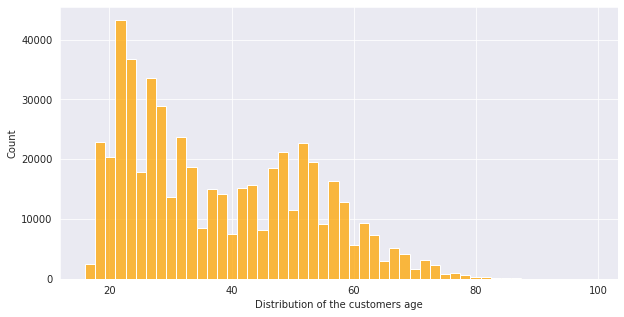

time: 509 ms (started: 2022-05-05 15:05:30 +00:00)


In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=sub_cust_na, x='age', bins=50, color='orange')
ax.set_xlabel('Distribution of the customers age')
plt.show()

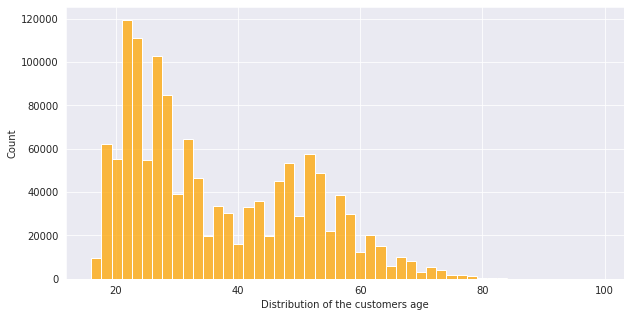

time: 1.75 s (started: 2022-05-05 15:06:24 +00:00)


In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=cust_df.to_pandas(), x='age', bins=50, color='orange')
ax.set_xlabel('Distribution of the customers age')
plt.show()

In [ ]:
data_postal = sub_cust_na.groupby('postal_code', as_index=False).count().sort_values('customer_id', ascending=False)
data_postal.head()

,postal_code,customer_id,customer_id2,age,customer_id_ignored,prediction,sim_1_prod,pair_item_id
41399,2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c,78844,78844,77283,0,0,0,0
191995,cc4ed85e30f4977dae47662ddc468cd2eec11472de6fac5ec985080fd92243c8,147,147,146,0,0,0,0
106262,714976379549eb90aae4a71bca6c7402cc646ae7c40f6c1cb91d4b5a18623fc1,98,98,97,0,0,0,0
40165,2ae1336f24a61e21cc88fe01ac908ef5a41bf009468ff5db939a759b7392cb42,67,67,67,0,0,0,0
106356,71613c3dfaf0b77dfeb606a33816aff4d7c4c7628b8ee555d4bd84bb14ad05bd,63,63,63,0,0,0,0


time: 1.08 s (started: 2022-05-05 15:07:18 +00:00)


In [ ]:
data_age = sub_cust_na.groupby('age', as_index=False).count().sort_values('customer_id', ascending=False)
data_age.head()

,age,customer_id,customer_id2,postal_code,customer_id_ignored,prediction,sim_1_prod,pair_item_id
5,21.0,24920,24920,24920,0,0,0,0
4,20.0,20334,20334,20334,0,0,0,0
6,22.0,18370,18370,18370,0,0,0,0
7,23.0,18355,18355,18355,0,0,0,0
8,24.0,18340,18340,18340,0,0,0,0


time: 185 ms (started: 2022-05-05 15:07:39 +00:00)


In [ ]:
dfCustomers = cust_df.to_pandas()
listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
dfCustomers['age_bins'] = pd.cut(dfCustomers['age'], listBin)

time: 1.14 s (started: 2022-05-05 15:14:30 +00:00)


In [ ]:
dfCustomers2 = sub_cust_na
listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
dfCustomers2['age_bins'] = pd.cut(dfCustomers2['age'], listBin)

time: 21.1 ms (started: 2022-05-05 15:15:35 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
x = dfCustomers[dfCustomers['age_bins'].isnull()].shape[0]
print(f'{x} customer_id do not have age information.\n')


15861 customer_id do not have age information.

time: 15.1 ms (started: 2022-05-05 15:15:05 +00:00)


In [ ]:
# Customers with no purchase in purchase_df_2
x = dfCustomers2[dfCustomers2['age_bins'].isnull()].shape[0]
print(f'{x} customer_id do not have age information.\n')


10226 customer_id do not have age information.

time: 10.3 ms (started: 2022-05-05 15:15:58 +00:00)


In [ ]:
dfCustomers.head()

,customer_id,age,postal_code,customer_id2,age_bins
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a91f8ca0d4b6efa8100,6883939031699146327,"(39, 49]"
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93f4c830291c32bc3057,-7200416642310594310,"(19, 29]"
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6c9090f7dd3e38380dc,-6846340800584936,"(19, 29]"
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c222539af5973a23ae6d,-94071612138601410,"(49, 59]"
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd4564743b005a805b1d,-283965518499174310,"(49, 59]"


time: 11.2 ms (started: 2022-05-05 15:18:19 +00:00)


In [ ]:
len(dfCustomers)

1371980

time: 2.8 ms (started: 2022-05-05 15:32:37 +00:00)


In [ ]:
dfTransactions = cudf.read_csv('/content/drive/MyDrive/CSCI_567_ML/Data/transactions_train.csv',  
                               usecols=['t_dat', 'customer_id', 'article_id'],
                               dtype={'article_id': 'int32', 't_dat': 'string', 'customer_id': 'string'})
dfTransactions['t_dat'] = cudf.to_datetime(dfTransactions['t_dat'])
dfTransactions.set_index('t_dat', inplace=True)

time: 5.78 s (started: 2022-05-05 15:17:32 +00:00)


In [ ]:
dfRecent = dfTransactions.loc['2020-09-01' : '2020-09-21']

time: 66.6 ms (started: 2022-05-05 15:17:58 +00:00)


In [ ]:
dfRecent = dfRecent.to_pandas()
dfRecent = dfRecent.merge(dfCustomers[['customer_id', 'age_bins']], on='customer_id', how='inner')

time: 926 ms (started: 2022-05-05 15:18:31 +00:00)


In [ ]:
dfRecent = dfRecent.groupby(['age_bins', 'article_id']).count().reset_index().rename(columns={'customer_id': 'counts'})

listUniBins = dfRecent['age_bins'].unique().tolist()

dict100 = {}
for uniBin in listUniBins:
    dfTemp = dfRecent[dfRecent['age_bins'] == uniBin]
    dfTemp = dfTemp.sort_values(by='counts', ascending=False)
    dict100[uniBin] = dfTemp.head(100)['article_id'].values.tolist()

df100 = pd.DataFrame([dict100]).T.rename(columns={0:'top100'})


time: 1.22 s (started: 2022-05-05 15:18:52 +00:00)


In [ ]:
dict100

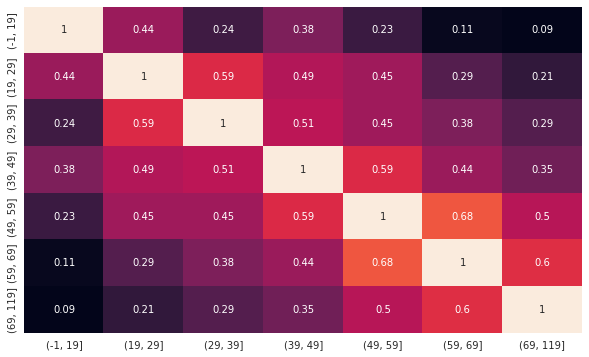

time: 444 ms (started: 2022-05-05 15:19:32 +00:00)


In [ ]:
for index in df100.index:
    df100[index] = [len(set(df100.at[index, 'top100']) & set(df100.at[x, 'top100']))/100 for x in df100.index]

df100 = df100.drop(columns='top100')
plt.figure(figsize=(10, 6))
sns.heatmap(df100, annot=True, cbar=False)

In [ ]:
N = 12
listUniBins = dfCustomers['age_bins'].unique().tolist()

time: 18.1 ms (started: 2022-05-05 15:19:50 +00:00)


In [ ]:
listUniBins

[Interval(39.0, 49.0, closed='right'),
 Interval(19.0, 29.0, closed='right'),
 Interval(49.0, 59.0, closed='right'),
 nan,
 Interval(29.0, 39.0, closed='right'),
 Interval(69.0, 119.0, closed='right'),
 Interval(59.0, 69.0, closed='right'),
 Interval(-1.0, 19.0, closed='right')]

time: 3.35 ms (started: 2022-05-05 15:22:12 +00:00)


In [ ]:
general_preds_age_wise = {}

time: 1.21 ms (started: 2022-05-05 15:23:01 +00:00)


In [ ]:
for uniBin in listUniBins:
    df  = cudf.read_csv('/content/drive/MyDrive/CSCI_567_ML/Data/transactions_train.csv',
                            usecols= ['t_dat', 'customer_id', 'article_id'], 
                            dtype={'article_id': 'int32', 't_dat': 'string', 'customer_id': 'string'})
    if str(uniBin) == 'nan':
        dfCustomersTemp = dfCustomers[dfCustomers['age_bins'].isnull()]
    else:
        dfCustomersTemp = dfCustomers[dfCustomers['age_bins'] == uniBin]
    
    dfCustomersTemp = dfCustomersTemp.drop(['age_bins'], axis=1)
    dfCustomersTemp = cudf.from_pandas(dfCustomersTemp)
    
    df = df.merge(dfCustomersTemp[['customer_id', 'age']], on='customer_id', how='inner')
    print(f'The shape of scope transaction for {uniBin} is {df.shape}. \n')
          
    df ['customer_id'] = df ['customer_id'].str[-16:].str.hex_to_int().astype('int64')
    df['t_dat'] = cudf.to_datetime(df['t_dat'])
    last_ts = df['t_dat'].max()

    tmp = df[['t_dat']].copy().to_pandas()
    tmp['dow'] = tmp['t_dat'].dt.dayofweek
    tmp['ldbw'] = tmp['t_dat'] - pd.TimedeltaIndex(tmp['dow'] - 1, unit='D')
    tmp.loc[tmp['dow'] >=2 , 'ldbw'] = tmp.loc[tmp['dow'] >=2 , 'ldbw'] + pd.TimedeltaIndex(np.ones(len(tmp.loc[tmp['dow'] >=2])) * 7, unit='D')

    df['ldbw'] = tmp['ldbw'].values
    
    weekly_sales = df.drop('customer_id', axis=1).groupby(['ldbw', 'article_id']).count().reset_index()
    weekly_sales = weekly_sales.rename(columns={'t_dat': 'count'})
    
    df = df.merge(weekly_sales, on=['ldbw', 'article_id'], how = 'left')
    
    weekly_sales = weekly_sales.reset_index().set_index('article_id')

    df = df.merge(
        weekly_sales.loc[weekly_sales['ldbw']==last_ts, ['count']],
        on='article_id', suffixes=("", "_targ"))

    df['count_targ'].fillna(0, inplace=True)
    del weekly_sales
    
    df['quotient'] = df['count_targ'] / df['count']
    
    target_sales = df.drop('customer_id', axis=1).groupby('article_id')['quotient'].sum()
    general_pred = target_sales.nlargest(N).index.to_pandas().tolist()
    general_pred = ['0' + str(article_id) for article_id in general_pred]
    general_pred_str =  ' '.join(general_pred)
    general_preds_age_wise[str(uniBin)] = general_pred
    del target_sales
    
    purchase_dict = {}

    tmp = df.copy().to_pandas()
    tmp['x'] = ((last_ts - tmp['t_dat']) / np.timedelta64(1, 'D')).astype(int)
    tmp['dummy_1'] = 1 
    tmp['x'] = tmp[["x", "dummy_1"]].max(axis=1)

    a, b, c, d = 2.5e4, 1.5e5, 2e-1, 1e3
    tmp['y'] = a / np.sqrt(tmp['x']) + b * np.exp(-c*tmp['x']) - d

    tmp['dummy_0'] = 0 
    tmp['y'] = tmp[["y", "dummy_0"]].max(axis=1)
    tmp['value'] = tmp['quotient'] * tmp['y'] 

    tmp = tmp.groupby(['customer_id', 'article_id']).agg({'value': 'sum'})
    tmp = tmp.reset_index()

    tmp = tmp.loc[tmp['value'] > 0]
    tmp['rank'] = tmp.groupby("customer_id")["value"].rank("dense", ascending=False)
    tmp = tmp.loc[tmp['rank'] <= 12]

    purchase_df = tmp.sort_values(['customer_id', 'value'], ascending = False).reset_index(drop = True)
    purchase_df['prediction'] = '0' + purchase_df['article_id'].astype(str) + ' '
    purchase_df = purchase_df.groupby('customer_id').agg({'prediction': sum}).reset_index()
    purchase_df['prediction'] = purchase_df['prediction'].str.strip()
    purchase_df = cudf.DataFrame(purchase_df)
    
    sub_2  = cudf.read_csv('/content/drive/MyDrive/CSCI_567_ML/Data/sample_submission.csv',
                            usecols= ['customer_id'], 
                            dtype={'customer_id': 'string'})
    
    numCustomers = sub_2.shape[0]
    
    sub_2 = sub_2.merge(dfCustomersTemp[['customer_id', 'age']], on='customer_id', how='inner')

    sub_2['customer_id2'] = sub_2['customer_id'].str[-16:].str.hex_to_int().astype('int64')

    sub_2 = sub_2.merge(purchase_df, left_on = 'customer_id2', right_on = 'customer_id', how = 'left',
                   suffixes = ('', '_ignored'))

    sub_2 = sub_2.to_pandas()
    sub_2['prediction'] = sub_2['prediction'].fillna(general_pred_str)
    sub_2['prediction'] = sub_2['prediction'] + ' ' +  general_pred_str
    sub_2['prediction'] = sub_2['prediction'].str.strip()
    sub_2['prediction'] = sub_2['prediction'].str[:131]
    sub_2 = sub_2[['customer_id', 'prediction']]
    sub_2.to_csv(f'submission_' + str(uniBin) + '.csv',index=False)
    print(f'Saved prediction for {uniBin}. The shape is {sub_2.shape}. \n')
    print('-'*50)
print('Finished.\n')
print('='*50)

The shape of scope transaction for (39.0, 49.0] is (4908363, 4). 



/usr/local/lib/python3.7/site-packages/cudf/core/frame.py:3079: FutureWarning: keep_index is deprecated and will be removed in the future.
  FutureWarning,


Saved prediction for (39.0, 49.0]. The shape is (204118, 2). 

--------------------------------------------------
The shape of scope transaction for (19.0, 29.0] is (13058587, 4). 

Saved prediction for (19.0, 29.0]. The shape is (528358, 2). 

--------------------------------------------------
The shape of scope transaction for (49.0, 59.0] is (5136958, 4). 

Saved prediction for (49.0, 59.0]. The shape is (226242, 2). 

--------------------------------------------------
The shape of scope transaction for nan is (140258, 4). 

Saved prediction for nan. The shape is (15861, 2). 

--------------------------------------------------
The shape of scope transaction for (29.0, 39.0] is (6428863, 4). 

Saved prediction for (29.0, 39.0]. The shape is (234068, 2). 

--------------------------------------------------
The shape of scope transaction for (69.0, 119.0] is (220067, 4). 

Saved prediction for (69.0, 119.0]. The shape is (19127, 2). 

--------------------------------------------------


In [ ]:
general_preds_age_wise

{Interval(-1.0, 19.0, closed='right'): ['0685813003',
  '0715624001',
  '0448509014',
  '0685814003',
  '0706016002',
  '0372860002',
  '0706016001',
  '0573085028',
  '0751471001',
  '0685813001',
  '0372860001',
  '0706016003'],
 Interval(19.0, 29.0, closed='right'): ['0448509014',
  '0573085028',
  '0706016001',
  '0706016003',
  '0158340001',
  '0715624001',
  '0372860002',
  '0372860001',
  '0751471001',
  '0685814001',
  '0706016002',
  '0610776002'],
 Interval(29.0, 39.0, closed='right'): ['0158340001',
  '0448509014',
  '0711053003',
  '0768912001',
  '0579541001',
  '0706016001',
  '0160442007',
  '0572797001',
  '0706016003',
  '0562245046',
  '0611415001',
  '0751471001'],
 Interval(39.0, 49.0, closed='right'): ['0751471001',
  '0448509014',
  '0579541001',
  '0706016001',
  '0673677002',
  '0573085028',
  '0706016002',
  '0762846006',
  '0715624001',
  '0372860001',
  '0685814001',
  '0610776002'],
 Interval(49.0, 59.0, closed='right'): ['0751471001',
  '0579541001',
  '057

time: 3.67 ms (started: 2022-05-05 15:26:45 +00:00)


In [ ]:
np.save('/content/drive/MyDrive/CSCI_567_ML/Data/general_preds_age_wise.npy', general_preds_age_wise)

time: 35.5 ms (started: 2022-05-05 15:29:39 +00:00)


## Build preduction list for submission

In [ ]:
purchase_df_2.head()

,customer_id,prediction,sim_1_prod,pair_item_id
0,-9223352921020755230,0673396002 0812167004 0849493006 0706016001 0568597006 0706016001 0812167002 0849493007 0706016002 0568601006 0721546002 0887771002 0852843001 0448515018 0714032001 0706016001 0812167002 0849493007 0706016002 0568601006 0721546002 0887771002 0852843001 0448515018 0714032001,0721546002 0887771002 0852843001 0448515018 0714032001,0706016001 0812167002 0849493007 0706016002 0568601006
1,-9223343869995384291,0908292002 0910601003 0903926002 0865929007 0821759001 0865929003 0849886010 0783346032 0849886012 0884319008 0927529004 0762846008 0706016001 0910601002 0903926001 0865929003 0827420001 0678342001 0849886012 0783346001 0849886010 0772005005 0927529001 0762846001 0610274009 0653229002 0546969002 0548479001 0689029005 0733098018 0912460001 0772345002 0849886006 0859153002 0866837002 0885543006 0706016001 0910601002 0903926001 0865929003 0827420001 0678342001 0849886012 0783346001 0849886010 0772005005 0927529001 0762846001 0610274009 0653229002 0546969002 0548479001 0689029005 0733098018 0912460001 0772345002 0849886006 0859153002 0866837002 0885543006,0610274009 0653229002 0546969002 0548479001 0689029005 0733098018 0912460001 0772345002 0849886006 0859153002 0866837002 0885543006,0706016001 0910601002 0903926001 0865929003 0827420001 0678342001 0849886012 0783346001 0849886010 0772005005 0927529001 0762846001
2,-9223295149301589789,0826620001 0706016001 0826505005 0706016001 0826505005,0826505005,0706016001
3,-9223293121067732640,0715624001 0456163060 0835008005 0557599022 0740922001 0814641002 0707269004 0834906001 0799409001 0795975009 0811925001 0745232001 0706016001 0706016001 0706016001 0611415001 0372860001 0814641001 0707269003 0707269001 0799410001 0795975003 0811927001 0706016001 0885803002 0885803002 0716075004 0557599011 0757303021 0753094013 0819113003 0700688006 0758808002 0824905002 0865594002 0722342003 0706016001 0706016001 0706016001 0611415001 0372860001 0814641001 0707269003 0707269001 0799410001 0795975003 0811927001 0706016001 0885803002 0885803002 0716075004 0557599011 0757303021 0753094013 0819113003 0700688006 0758808002 0824905002 0865594002 0722342003,0885803002 0885803002 0716075004 0557599011 0757303021 0753094013 0819113003 0700688006 0758808002 0824905002 0865594002 0722342003,0706016001 0706016001 0706016001 0611415001 0372860001 0814641001 0707269003 0707269001 0799410001 0795975003 0811927001 0706016001
4,-9223290575350349271,0852584006 0905518001 0912204009 0757904007 0733067001 0783346001 0473954015 0536139006 0278811006 0730683050 0905518002 0912204001 0706016001 0473954008 0751471001 0473954008 0706016001 0706016001 0375248012 0411413001 0647060002 0760880001 0702932036 0684968001 0473954014 0713380002 0777280001 0730683050 0905518002 0912204001 0706016001 0473954008 0751471001 0473954008 0706016001 0706016001 0375248012 0411413001 0647060002 0760880001 0702932036 0684968001 0473954014 0713380002 0777280001,0375248012 0411413001 0647060002 0760880001 0702932036 0684968001 0473954014 0713380002 0777280001,0730683050 0905518002 0912204001 0706016001 0473954008 0751471001 0473954008 0706016001 0706016001


time: 18.4 ms (started: 2022-05-05 14:53:57 +00:00)


In [ ]:
sub  = cudf.read_csv('/content/drive/MyDrive/CSCI_567_ML/Data/sample_submission.csv',
                            usecols= ['customer_id'], 
                            dtype={'customer_id': 'string'})

sub['customer_id2'] = sub['customer_id'].str[-16:].str.hex_to_int().astype('int64')

time: 346 ms (started: 2022-05-05 15:32:50 +00:00)


In [ ]:
sub = sub.merge(purchase_df_2, left_on = 'customer_id2', right_on = 'customer_id', how = 'left',
               suffixes = ('', '_ignored'))
sub = sub.to_pandas()

time: 1.7 s (started: 2022-05-05 15:32:51 +00:00)


In [ ]:
# Check total customers with 0 purchases
sub['prediction'].isna().sum()
sub_cust_na = sub[sub['prediction'].isna()]


534009

time: 101 ms (started: 2022-05-05 15:33:13 +00:00)


In [ ]:
sub_cust_not_na = sub[~sub['prediction'].isna()]

time: 217 ms (started: 2022-05-05 15:40:46 +00:00)


In [ ]:
sub_cust_not_na.head()

,customer_id,customer_id2,customer_id_ignored,prediction,sim_1_prod,pair_item_id
0,0033a299f05a52d0de2233b729da572aeab07eb9b986534ee06d57dca2128f31,-2275065631628685519,-2.275066e+18,0863595005 0925978001 0827760001 0562245104 0265630006 0711053007 0902161005 0829882004 0806388003 0860322004 0853881001 0863595006 0111593001 0751471001 0399256005 0372860001 0711053003 0706016001 0853881001 0806388001 0860322001 0720125001 0660599009 0651859003 0837139001 0558981019 0696536004 0806388011 0923083001 0442345024 0649440025 0739529001 0734870001 0863595006 0111593001 0751471001 0399256005 0372860001 0711053003 0706016001 0853881001 0806388001 0860322001 0720125001 0660599009 0651859003 0837139001 0558981019 0696536004 0806388011 0923083001 0442345024 0649440025 0739529001 0734870001,0660599009 0651859003 0837139001 0558981019 0696536004 0806388011 0923083001 0442345024 0649440025 0739529001 0734870001,0863595006 0111593001 0751471001 0399256005 0372860001 0711053003 0706016001 0853881001 0806388001 0860322001 0720125001
1,0033c253ee4c93f7b00e8fbaf19c645854d3362429e54f215c0983576a99b0c4,6631976337753616580,6.631976e+18,0871997001 0871997002 0849586002 0665481013 0871997002 0871997001 0849586004 0706016001 0643169002 0861123001 0778534007 0665481010 0871997002 0871997001 0849586004 0706016001 0643169002 0861123001 0778534007 0665481010,0643169002 0861123001 0778534007 0665481010,0871997002 0871997001 0849586004 0706016001
2,00341ad1496a3ae85865f363374a231650dd214504979060d986131f03573ff2,-2772507496678998030,-2.772507e+18,0826500007 0156231001 0662948005 0156231001 0662948005,0662948005,0156231001
3,00342c6b8ff83f7e5cdc3150630831662e98be97da3dd30ac3d23f1312e61e60,-4336334140050366880,-4.336334e+18,0772902001 0591466024 0772902004 0358753001 0706016001 0685816002 0772902001 0706016001 0618894011 0609483011 0549639001 0885077002 0706016001 0685816002 0772902001 0706016001 0618894011 0609483011 0549639001 0885077002,0618894011 0609483011 0549639001 0885077002,0706016001 0685816002 0772902001 0706016001
4,0033d044f191f956a60f857cbda8fb815e4634f1f5ff51eebd537e380dff33f6,-4804357598256090122,-4.804358e+18,0448509014 0806388002 0806388001 0511105002 0598515020 0778064003 0778064001 0727611004 0841228002 0761418004 0677930066 0598515024 0706016001 0806388001 0806388002 0706016001 0598515018 0778064001 0778064003 0706016001 0610776002 0706016001 0706016001 0372860001 0900170001 0763275001 0849588002 0296366034 0757971003 0825720006 0717490001 0872813003 0793104005 0816487001 0771759003 0598515013 0706016001 0806388001 0806388002 0706016001 0598515018 0778064001 0778064003 0706016001 0610776002 0706016001 0706016001 0372860001 0900170001 0763275001 0849588002 0296366034 0757971003 0825720006 0717490001 0872813003 0793104005 0816487001 0771759003 0598515013,0900170001 0763275001 0849588002 0296366034 0757971003 0825720006 0717490001 0872813003 0793104005 0816487001 0771759003 0598515013,0706016001 0806388001 0806388002 0706016001 0598515018 0778064001 0778064003 0706016001 0610776002 0706016001 0706016001 0372860001


time: 10.5 ms (started: 2022-05-05 15:41:14 +00:00)


In [ ]:
general_pred_str

'0685813003 0715624001 0448509014 0685814003 0706016002 0372860002 0706016001 0573085028 0751471001 0685813001 0372860001 0706016003'

time: 2.37 ms (started: 2022-05-05 15:32:54 +00:00)


In [ ]:
sub_cust_na['age_bins'] = pd.cut(sub_cust_na['age'], listBin)

time: 22.9 ms (started: 2022-05-05 15:33:55 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
sub_cust_na.head()

,customer_id,customer_id2,age,postal_code,customer_id_ignored,prediction,sim_1_prod,pair_item_id,age_bins
6,0033cee00a5c5f2d39799c73030854e7f70889e7086a47f67f20a11c909ed9b1,9160498786129074609,18.0,bc85b91a1cfb9245dd3dde296d76224c760f19cc92ddc577d6aaea84efe888f2,NaN,None,None,None,"(-1, 19]"
7,00340ad83be6af0aa93d1630e9fde93d03f54352aaf3e93d8b658a637298b2c2,-8402157370060787006,22.0,cc8f894b53f8417f738b841868e0178e28c98dfaeba69f67080d83850ffca624,NaN,None,None,None,"(19, 29]"
8,00342135828538b9e2992e5aa699f287bb030c44faa3a5852b64090424ab8869,3126633954701707369,47.0,e606449ebc40d2fd38e96590c931a5535972cf734bbf6113d91f522894b4dffd,NaN,None,None,None,"(39, 49]"
9,0033d183c311ccf1b4bb1767baeaa60d8697d314fe256b4fcbaf212ece854b9c,-3769757878168761444,49.0,6ddcdd3d8c4e0845727ad5735174a6ca3b1f1537069e95fa63d3672b4e029021,NaN,None,None,None,"(39, 49]"
10,0033ed9017159dac227bd3fbcad9877bb61bc1b640a37eb2ff9c6871926aac30,-28032660674008016,20.0,2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c,NaN,None,None,None,"(19, 29]"


time: 19.5 ms (started: 2022-05-05 15:34:00 +00:00)


In [ ]:
x = sub_cust_na[sub_cust_na['age_bins'].isnull()].shape[0]
print(f'{x} customer_id do not have age information.\n')

10226 customer_id do not have age information.

time: 15.3 ms (started: 2022-05-05 15:36:10 +00:00)


In [ ]:
# Join sub_cust_na with age wise general pred
for uniBin in listUniBins:
  print(uniBin)
# age_buckets = list(general_preds_age_wise.keys())


(39.0, 49.0]
(19.0, 29.0]
(49.0, 59.0]
nan
(29.0, 39.0]
(69.0, 119.0]
(59.0, 69.0]
(-1.0, 19.0]
time: 2.87 ms (started: 2022-05-05 15:49:29 +00:00)


In [ ]:
df_list = []

time: 938 µs (started: 2022-05-05 15:59:52 +00:00)


In [ ]:
for uniBin in listUniBins:
    print(uniBin)
    if str(uniBin) == 'nan':
        dfCustomersTemp = sub_cust_na[sub_cust_na['age_bins'].isnull()]
    else:
        dfCustomersTemp = sub_cust_na[sub_cust_na['age_bins'] == uniBin]
    print(general_preds_age_wise[uniBin])
    dfCustomersTemp['prediction'] = ' '.join(general_preds_age_wise[uniBin])

    df_list.append(dfCustomersTemp)

(39.0, 49.0]
['0751471001', '0448509014', '0579541001', '0706016001', '0673677002', '0573085028', '0706016002', '0762846006', '0715624001', '0372860001', '0685814001', '0610776002']
(19.0, 29.0]
['0448509014', '0573085028', '0706016001', '0706016003', '0158340001', '0715624001', '0372860002', '0372860001', '0751471001', '0685814001', '0706016002', '0610776002']
(49.0, 59.0]
['0751471001', '0579541001', '0573085028', '0673677002', '0678942001', '0448509014', '0562245046', '0706016001', '0372860002', '0554598001', '0762846006', '0568601006']
nan
['0372860001', '0448509014', '0111593001', '0706016003', '0658030011', '0719530003', '0706016002', '0399256001', '0399223001', '0579541001', '0767869001', '0610776001']
(29.0, 39.0]
['0158340001', '0448509014', '0711053003', '0768912001', '0579541001', '0706016001', '0160442007', '0572797001', '0706016003', '0562245046', '0611415001', '0751471001']
(69.0, 119.0]
['0579541001', '0678942001', '0751471001', '0783346001', '0399256023', '0664074001', 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
sub_cust_na_filled = pd.concat(
    df_list,
    axis=0,
    join="outer",
    ignore_index=False,
    keys=None,
    levels=None,
    names=None,
    verify_integrity=False,
    copy=True,
)

time: 113 ms (started: 2022-05-05 16:07:22 +00:00)


In [ ]:
sub_cust_all_filled = pd.concat(
    [sub_cust_not_na, sub_cust_na_filled],
    axis=0,
    join="outer",
    ignore_index=False,
    keys=None,
    levels=None,
    names=None,
    verify_integrity=False,
    copy=True,
)

time: 230 ms (started: 2022-05-05 16:07:30 +00:00)


In [ ]:
len(sub_cust_all_filled)

1371980

time: 2.98 ms (started: 2022-05-05 16:07:37 +00:00)


In [ ]:
len(sub_cust_na_filled) + len(sub_cust_not_na)


1371980

time: 2.41 ms (started: 2022-05-05 16:07:24 +00:00)


In [ ]:
sub_cust_na_filled.head()

,customer_id,customer_id2,age,postal_code,customer_id_ignored,prediction,sim_1_prod,pair_item_id,age_bins
8,00342135828538b9e2992e5aa699f287bb030c44faa3a5852b64090424ab8869,3126633954701707369,47.0,e606449ebc40d2fd38e96590c931a5535972cf734bbf6113d91f522894b4dffd,NaN,0751471001 0448509014 0579541001 0706016001 0673677002 0573085028 0706016002 0762846006 0715624001 0372860001 0685814001 0610776002,None,None,"(39, 49]"
9,0033d183c311ccf1b4bb1767baeaa60d8697d314fe256b4fcbaf212ece854b9c,-3769757878168761444,49.0,6ddcdd3d8c4e0845727ad5735174a6ca3b1f1537069e95fa63d3672b4e029021,NaN,0751471001 0448509014 0579541001 0706016001 0673677002 0573085028 0706016002 0762846006 0715624001 0372860001 0685814001 0610776002,None,None,"(39, 49]"
30,038225443a2f0455f952bccbd1b59a54bd91619a62150795228e382cb7c75b3b,2489989408695475003,40.0,9e5255dc57cecf1de30c37a6b081877b841481a43a1c77e4ac3aa919dc208cd0,NaN,0751471001 0448509014 0579541001 0706016001 0673677002 0573085028 0706016002 0762846006 0715624001 0372860001 0685814001 0610776002,None,None,"(39, 49]"
47,00de2b4c8acff9723978e020a0fc7e71b78e1bd334cb9437fb5009242cd4528e,-337759921077202290,43.0,494c8dd0e1e99d4c6e08fbb400327c77c42b81b5c0bf2482f87cfe135bb748d7,NaN,0751471001 0448509014 0579541001 0706016001 0673677002 0573085028 0706016002 0762846006 0715624001 0372860001 0685814001 0610776002,None,None,"(39, 49]"
59,021b5000d0de9e5a5e3d43e29f4a64338981fd4ff8dcf6601113318ab57dfc63,1230381595022457955,41.0,e634329c2b6fba636f9eca433a55fe409884945981794c383d1050c7786ac8f0,NaN,0751471001 0448509014 0579541001 0706016001 0673677002 0573085028 0706016002 0762846006 0715624001 0372860001 0685814001 0610776002,None,None,"(39, 49]"


time: 12.1 ms (started: 2022-05-05 16:00:24 +00:00)


In [ ]:
sub_cust_na.head()

,customer_id,customer_id2,age,postal_code,customer_id_ignored,prediction,sim_1_prod,pair_item_id,age_bins
6,0033cee00a5c5f2d39799c73030854e7f70889e7086a47f67f20a11c909ed9b1,9160498786129074609,18.0,bc85b91a1cfb9245dd3dde296d76224c760f19cc92ddc577d6aaea84efe888f2,NaN,None,None,None,"(-1, 19]"
7,00340ad83be6af0aa93d1630e9fde93d03f54352aaf3e93d8b658a637298b2c2,-8402157370060787006,22.0,cc8f894b53f8417f738b841868e0178e28c98dfaeba69f67080d83850ffca624,NaN,None,None,None,"(19, 29]"
8,00342135828538b9e2992e5aa699f287bb030c44faa3a5852b64090424ab8869,3126633954701707369,47.0,e606449ebc40d2fd38e96590c931a5535972cf734bbf6113d91f522894b4dffd,NaN,None,None,None,"(39, 49]"
9,0033d183c311ccf1b4bb1767baeaa60d8697d314fe256b4fcbaf212ece854b9c,-3769757878168761444,49.0,6ddcdd3d8c4e0845727ad5735174a6ca3b1f1537069e95fa63d3672b4e029021,NaN,None,None,None,"(39, 49]"
10,0033ed9017159dac227bd3fbcad9877bb61bc1b640a37eb2ff9c6871926aac30,-28032660674008016,20.0,2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c,NaN,None,None,None,"(19, 29]"


time: 14.5 ms (started: 2022-05-05 16:00:35 +00:00)


In [ ]:
dfCustomersTemp.head()

,customer_id,customer_id2,age,postal_code,customer_id_ignored,prediction,sim_1_prod,pair_item_id,age_bins
6,0033cee00a5c5f2d39799c73030854e7f70889e7086a47f67f20a11c909ed9b1,9160498786129074609,18.0,bc85b91a1cfb9245dd3dde296d76224c760f19cc92ddc577d6aaea84efe888f2,NaN,0685813003 0715624001 0448509014 0685814003 0706016002 0372860002 0706016001 0573085028 0751471001 0685813001 0372860001 0706016003,None,None,"(-1, 19]"
13,0034287496a68969433597150ed9962b70e1c44d671714e62863d9994b559a41,2910409036628597313,19.0,da73bdfea722af87d11988884a4d9cbcbd1e899d76c85a8c218db72e35270a5e,NaN,0685813003 0715624001 0448509014 0685814003 0706016002 0372860002 0706016001 0573085028 0751471001 0685813001 0372860001 0706016003,None,None,"(-1, 19]"
41,00dd6783ec25af789ee511cde9a079310e345576c0b8f603062a2aa1348e58ed,444214385109260525,17.0,e4aa66f30b5b3659c7654ef21ff69de3a815974aba43a911ac36f20cff354663,NaN,0685813003 0715624001 0448509014 0685814003 0706016002 0372860002 0706016001 0573085028 0751471001 0685813001 0372860001 0706016003,None,None,"(-1, 19]"
77,022ca8f13001b8e5ccc9ffff597300c21fffe7cfc984ff2111524383b72990b3,1248134279727780019,18.0,47be41171b90d8a7d3df956c231e37b40ea9d27fabf685214d1faff8ca3d2b26,NaN,0685813003 0715624001 0448509014 0685814003 0706016002 0372860002 0706016001 0573085028 0751471001 0685813001 0372860001 0706016003,None,None,"(-1, 19]"
86,01bf435e1c22789fbf9d736e9faf67402a6abd3f6b9a5d2ca1ce10f73e35c338,-6787468934314081480,18.0,72b6742ec969c1a6d124490d80324889c51ff95e6ee59250046428781d740107,NaN,0685813003 0715624001 0448509014 0685814003 0706016002 0372860002 0706016001 0573085028 0751471001 0685813001 0372860001 0706016003,None,None,"(-1, 19]"


time: 19.5 ms (started: 2022-05-05 15:52:40 +00:00)


In [ ]:
# If the customer has purchased nothing, fill predictions from general prediction
sub['prediction'] = sub['prediction'].fillna(general_pred_str)

time: 188 ms (started: 2022-05-05 16:08:40 +00:00)


In [ ]:
sub['prediction'].isna().sum()

534009

time: 98.9 ms (started: 2022-05-05 16:07:59 +00:00)


In [ ]:
sub_cust_all_filled['prediction'].isna().sum()

0

time: 113 ms (started: 2022-05-05 16:08:11 +00:00)


In [ ]:
sub['prediction'] = sub['prediction'] + ' ' +  general_pred_str

time: 836 ms (started: 2022-05-05 16:08:44 +00:00)


In [ ]:
sub_cust_all_filled['prediction'] = sub_cust_all_filled['prediction'] + ' ' +  general_pred_str

time: 862 ms (started: 2022-05-05 16:10:19 +00:00)


In [ ]:
sub.head()

,customer_id,customer_id2,customer_id_ignored,prediction,sim_1_prod,pair_item_id
0,0033a299f05a52d0de2233b729da572aeab07eb9b986534ee06d57dca2128f31,-2275065631628685519,-2.275066e+18,0863595005 0925978001 0827760001 0562245104 0265630006 0711053007 0902161005 0829882004 0806388003 0860322004 0853881001 0863595006 0111593001 0751471001 0399256005 0372860001 0711053003 0706016001 0853881001 0806388001 0860322001 0720125001 0660599009 0651859003 0837139001 0558981019 0696536004 0806388011 0923083001 0442345024 0649440025 0739529001 0734870001 0863595006 0111593001 0751471001 0399256005 0372860001 0711053003 0706016001 0853881001 0806388001 0860322001 0720125001 0660599009 0651859003 0837139001 0558981019 0696536004 0806388011 0923083001 0442345024 0649440025 0739529001 0734870001 0685813003 0715624001 0448509014 0685814003 0706016002 0372860002 0706016001 0573085028 0751471001 0685813001 0372860001 0706016003,0660599009 0651859003 0837139001 0558981019 0696536004 0806388011 0923083001 0442345024 0649440025 0739529001 0734870001,0863595006 0111593001 0751471001 0399256005 0372860001 0711053003 0706016001 0853881001 0806388001 0860322001 0720125001
1,0033c253ee4c93f7b00e8fbaf19c645854d3362429e54f215c0983576a99b0c4,6631976337753616580,6.631976e+18,0871997001 0871997002 0849586002 0665481013 0871997002 0871997001 0849586004 0706016001 0643169002 0861123001 0778534007 0665481010 0871997002 0871997001 0849586004 0706016001 0643169002 0861123001 0778534007 0665481010 0685813003 0715624001 0448509014 0685814003 0706016002 0372860002 0706016001 0573085028 0751471001 0685813001 0372860001 0706016003,0643169002 0861123001 0778534007 0665481010,0871997002 0871997001 0849586004 0706016001
2,00341ad1496a3ae85865f363374a231650dd214504979060d986131f03573ff2,-2772507496678998030,-2.772507e+18,0826500007 0156231001 0662948005 0156231001 0662948005 0685813003 0715624001 0448509014 0685814003 0706016002 0372860002 0706016001 0573085028 0751471001 0685813001 0372860001 0706016003,0662948005,0156231001
3,00342c6b8ff83f7e5cdc3150630831662e98be97da3dd30ac3d23f1312e61e60,-4336334140050366880,-4.336334e+18,0772902001 0591466024 0772902004 0358753001 0706016001 0685816002 0772902001 0706016001 0618894011 0609483011 0549639001 0885077002 0706016001 0685816002 0772902001 0706016001 0618894011 0609483011 0549639001 0885077002 0685813003 0715624001 0448509014 0685814003 0706016002 0372860002 0706016001 0573085028 0751471001 0685813001 0372860001 0706016003,0618894011 0609483011 0549639001 0885077002,0706016001 0685816002 0772902001 0706016001
4,0033d044f191f956a60f857cbda8fb815e4634f1f5ff51eebd537e380dff33f6,-4804357598256090122,-4.804358e+18,0448509014 0806388002 0806388001 0511105002 0598515020 0778064003 0778064001 0727611004 0841228002 0761418004 0677930066 0598515024 0706016001 0806388001 0806388002 0706016001 0598515018 0778064001 0778064003 0706016001 0610776002 0706016001 0706016001 0372860001 0900170001 0763275001 0849588002 0296366034 0757971003 0825720006 0717490001 0872813003 0793104005 0816487001 0771759003 0598515013 0706016001 0806388001 0806388002 0706016001 0598515018 0778064001 0778064003 0706016001 0610776002 0706016001 0706016001 0372860001 0900170001 0763275001 0849588002 0296366034 0757971003 0825720006 0717490001 0872813003 0793104005 0816487001 0771759003 0598515013 0685813003 0715624001 0448509014 0685814003 0706016002 0372860002 0706016001 0573085028 0751471001 0685813001 0372860001 0706016003,0900170001 0763275001 0849588002 0296366034 0757971003 0825720006 0717490001 0872813003 0793104005 0816487001 0771759003 0598515013,0706016001 0806388001 0806388002 0706016001 0598515018 0778064001 0778064003 0706016001 0610776002 0706016001 0706016001 0372860001


time: 25.8 ms (started: 2022-05-05 16:09:01 +00:00)


In [ ]:
sub_cust_all_filled.head()

,customer_id,customer_id2,customer_id_ignored,prediction,sim_1_prod,pair_item_id,age,postal_code,age_bins
0,0033a299f05a52d0de2233b729da572aeab07eb9b986534ee06d57dca2128f31,-2275065631628685519,-2.275066e+18,0863595005 0925978001 0827760001 0562245104 0265630006 0711053007 0902161005 0829882004 0806388003 0860322004 0853881001 0863595006 0111593001 0751471001 0399256005 0372860001 0711053003 0706016001 0853881001 0806388001 0860322001 0720125001 0660599009 0651859003 0837139001 0558981019 0696536004 0806388011 0923083001 0442345024 0649440025 0739529001 0734870001 0863595006 0111593001 0751471001 0399256005 0372860001 0711053003 0706016001 0853881001 0806388001 0860322001 0720125001 0660599009 0651859003 0837139001 0558981019 0696536004 0806388011 0923083001 0442345024 0649440025 0739529001 0734870001 0685813003 0715624001 0448509014 0685814003 0706016002 0372860002 0706016001 0573085028 0751471001 0685813001 0372860001 0706016003,0660599009 0651859003 0837139001 0558981019 0696536004 0806388011 0923083001 0442345024 0649440025 0739529001 0734870001,0863595006 0111593001 0751471001 0399256005 0372860001 0711053003 0706016001 0853881001 0806388001 0860322001 0720125001,NaN,NaN,NaN
1,0033c253ee4c93f7b00e8fbaf19c645854d3362429e54f215c0983576a99b0c4,6631976337753616580,6.631976e+18,0871997001 0871997002 0849586002 0665481013 0871997002 0871997001 0849586004 0706016001 0643169002 0861123001 0778534007 0665481010 0871997002 0871997001 0849586004 0706016001 0643169002 0861123001 0778534007 0665481010 0685813003 0715624001 0448509014 0685814003 0706016002 0372860002 0706016001 0573085028 0751471001 0685813001 0372860001 0706016003,0643169002 0861123001 0778534007 0665481010,0871997002 0871997001 0849586004 0706016001,NaN,NaN,NaN
2,00341ad1496a3ae85865f363374a231650dd214504979060d986131f03573ff2,-2772507496678998030,-2.772507e+18,0826500007 0156231001 0662948005 0156231001 0662948005 0685813003 0715624001 0448509014 0685814003 0706016002 0372860002 0706016001 0573085028 0751471001 0685813001 0372860001 0706016003,0662948005,0156231001,NaN,NaN,NaN
3,00342c6b8ff83f7e5cdc3150630831662e98be97da3dd30ac3d23f1312e61e60,-4336334140050366880,-4.336334e+18,0772902001 0591466024 0772902004 0358753001 0706016001 0685816002 0772902001 0706016001 0618894011 0609483011 0549639001 0885077002 0706016001 0685816002 0772902001 0706016001 0618894011 0609483011 0549639001 0885077002 0685813003 0715624001 0448509014 0685814003 0706016002 0372860002 0706016001 0573085028 0751471001 0685813001 0372860001 0706016003,0618894011 0609483011 0549639001 0885077002,0706016001 0685816002 0772902001 0706016001,NaN,NaN,NaN
4,0033d044f191f956a60f857cbda8fb815e4634f1f5ff51eebd537e380dff33f6,-4804357598256090122,-4.804358e+18,0448509014 0806388002 0806388001 0511105002 0598515020 0778064003 0778064001 0727611004 0841228002 0761418004 0677930066 0598515024 0706016001 0806388001 0806388002 0706016001 0598515018 0778064001 0778064003 0706016001 0610776002 0706016001 0706016001 0372860001 0900170001 0763275001 0849588002 0296366034 0757971003 0825720006 0717490001 0872813003 0793104005 0816487001 0771759003 0598515013 0706016001 0806388001 0806388002 0706016001 0598515018 0778064001 0778064003 0706016001 0610776002 0706016001 0706016001 0372860001 0900170001 0763275001 0849588002 0296366034 0757971003 0825720006 0717490001 0872813003 0793104005 0816487001 0771759003 0598515013 0685813003 0715624001 0448509014 0685814003 0706016002 0372860002 0706016001 0573085028 0751471001 0685813001 0372860001 0706016003,0900170001 0763275001 0849588002 0296366034 0757971003 0825720006 0717490001 0872813003 0793104005 0816487001 0771759003 0598515013,0706016001 0806388001 0806388002 0706016001 0598515018 0778064001 0778064003 0706016001 0610776002 0706016001 0706016001 0372860001,NaN,NaN,NaN


time: 29.4 ms (started: 2022-05-05 16:10:24 +00:00)


In [ ]:
sub['prediction'] = sub['prediction'].str.strip()
sub_cust_all_filled['prediction'] = sub_cust_all_filled['prediction'].str.strip()


time: 1.96 s (started: 2022-05-05 16:10:43 +00:00)


In [ ]:
sub['prediction'] = sub['prediction'].str[:131]
sub_cust_all_filled['prediction'] = sub_cust_all_filled['prediction'].str[:131]


time: 1.95 s (started: 2022-05-05 16:10:51 +00:00)


In [ ]:
sub.head()

,customer_id,customer_id2,customer_id_ignored,prediction,sim_1_prod,pair_item_id
0,0033a299f05a52d0de2233b729da572aeab07eb9b986534ee06d57dca2128f31,-2275065631628685519,-2.275066e+18,0863595005 0925978001 0827760001 0562245104 0265630006 0711053007 0902161005 0829882004 0806388003 0860322004 0853881001 0863595006,0660599009 0651859003 0837139001 0558981019 0696536004 0806388011 0923083001 0442345024 0649440025 0739529001 0734870001,0863595006 0111593001 0751471001 0399256005 0372860001 0711053003 0706016001 0853881001 0806388001 0860322001 0720125001
1,0033c253ee4c93f7b00e8fbaf19c645854d3362429e54f215c0983576a99b0c4,6631976337753616580,6.631976e+18,0871997001 0871997002 0849586002 0665481013 0871997002 0871997001 0849586004 0706016001 0643169002 0861123001 0778534007 0665481010,0643169002 0861123001 0778534007 0665481010,0871997002 0871997001 0849586004 0706016001
2,00341ad1496a3ae85865f363374a231650dd214504979060d986131f03573ff2,-2772507496678998030,-2.772507e+18,0826500007 0156231001 0662948005 0156231001 0662948005 0685813003 0715624001 0448509014 0685814003 0706016002 0372860002 0706016001,0662948005,0156231001
3,00342c6b8ff83f7e5cdc3150630831662e98be97da3dd30ac3d23f1312e61e60,-4336334140050366880,-4.336334e+18,0772902001 0591466024 0772902004 0358753001 0706016001 0685816002 0772902001 0706016001 0618894011 0609483011 0549639001 0885077002,0618894011 0609483011 0549639001 0885077002,0706016001 0685816002 0772902001 0706016001
4,0033d044f191f956a60f857cbda8fb815e4634f1f5ff51eebd537e380dff33f6,-4804357598256090122,-4.804358e+18,0448509014 0806388002 0806388001 0511105002 0598515020 0778064003 0778064001 0727611004 0841228002 0761418004 0677930066 0598515024,0900170001 0763275001 0849588002 0296366034 0757971003 0825720006 0717490001 0872813003 0793104005 0816487001 0771759003 0598515013,0706016001 0806388001 0806388002 0706016001 0598515018 0778064001 0778064003 0706016001 0610776002 0706016001 0706016001 0372860001


time: 9.65 ms (started: 2022-05-05 16:10:53 +00:00)


In [ ]:
sub_cust_all_filled.head()

,customer_id,customer_id2,customer_id_ignored,prediction,sim_1_prod,pair_item_id,age,postal_code,age_bins
0,0033a299f05a52d0de2233b729da572aeab07eb9b986534ee06d57dca2128f31,-2275065631628685519,-2.275066e+18,0863595005 0925978001 0827760001 0562245104 0265630006 0711053007 0902161005 0829882004 0806388003 0860322004 0853881001 0863595006,0660599009 0651859003 0837139001 0558981019 0696536004 0806388011 0923083001 0442345024 0649440025 0739529001 0734870001,0863595006 0111593001 0751471001 0399256005 0372860001 0711053003 0706016001 0853881001 0806388001 0860322001 0720125001,NaN,NaN,NaN
1,0033c253ee4c93f7b00e8fbaf19c645854d3362429e54f215c0983576a99b0c4,6631976337753616580,6.631976e+18,0871997001 0871997002 0849586002 0665481013 0871997002 0871997001 0849586004 0706016001 0643169002 0861123001 0778534007 0665481010,0643169002 0861123001 0778534007 0665481010,0871997002 0871997001 0849586004 0706016001,NaN,NaN,NaN
2,00341ad1496a3ae85865f363374a231650dd214504979060d986131f03573ff2,-2772507496678998030,-2.772507e+18,0826500007 0156231001 0662948005 0156231001 0662948005 0685813003 0715624001 0448509014 0685814003 0706016002 0372860002 0706016001,0662948005,0156231001,NaN,NaN,NaN
3,00342c6b8ff83f7e5cdc3150630831662e98be97da3dd30ac3d23f1312e61e60,-4336334140050366880,-4.336334e+18,0772902001 0591466024 0772902004 0358753001 0706016001 0685816002 0772902001 0706016001 0618894011 0609483011 0549639001 0885077002,0618894011 0609483011 0549639001 0885077002,0706016001 0685816002 0772902001 0706016001,NaN,NaN,NaN
4,0033d044f191f956a60f857cbda8fb815e4634f1f5ff51eebd537e380dff33f6,-4804357598256090122,-4.804358e+18,0448509014 0806388002 0806388001 0511105002 0598515020 0778064003 0778064001 0727611004 0841228002 0761418004 0677930066 0598515024,0900170001 0763275001 0849588002 0296366034 0757971003 0825720006 0717490001 0872813003 0793104005 0816487001 0771759003 0598515013,0706016001 0806388001 0806388002 0706016001 0598515018 0778064001 0778064003 0706016001 0610776002 0706016001 0706016001 0372860001,NaN,NaN,NaN


time: 13.5 ms (started: 2022-05-05 16:15:48 +00:00)


In [ ]:
general_pred_str

'0685813003 0715624001 0448509014 0685814003 0706016002 0372860002 0706016001 0573085028 0751471001 0685813001 0372860001 0706016003'

time: 2.97 ms (started: 2022-05-05 16:11:21 +00:00)


In [ ]:
sub[sub['prediction'] == general_pred_str].count()

customer_id            534009
customer_id2           534009
customer_id_ignored    0     
prediction             534009
sim_1_prod             0     
pair_item_id           0     
dtype: int64

time: 553 ms (started: 2022-05-05 16:12:13 +00:00)


In [ ]:
sub_cust_all_filled[sub_cust_all_filled['prediction'] == general_pred_str].count()
# sub_cust_all_filled['prediction'] = sub_cust_all_filled['prediction'].str[:131]


customer_id            25449
customer_id2           25449
customer_id_ignored    0    
prediction             25449
sim_1_prod             0    
pair_item_id           0    
age                    25449
postal_code            25449
age_bins               25449
dtype: int64

time: 439 ms (started: 2022-05-05 16:16:20 +00:00)


In [ ]:
sub = sub[['customer_id', 'prediction']]

time: 53.4 ms (started: 2022-05-05 14:48:03 +00:00)


In [ ]:
sub_cust_all_filled = sub_cust_all_filled[['customer_id', 'prediction']]

time: 68.1 ms (started: 2022-05-05 16:17:19 +00:00)


In [ ]:
sub_cust_all_filled.head()

,customer_id,prediction
0,0033a299f05a52d0de2233b729da572aeab07eb9b986534ee06d57dca2128f31,0863595005 0925978001 0827760001 0562245104 0265630006 0711053007 0902161005 0829882004 0806388003 0860322004 0853881001 0863595006
1,0033c253ee4c93f7b00e8fbaf19c645854d3362429e54f215c0983576a99b0c4,0871997001 0871997002 0849586002 0665481013 0871997002 0871997001 0849586004 0706016001 0643169002 0861123001 0778534007 0665481010
2,00341ad1496a3ae85865f363374a231650dd214504979060d986131f03573ff2,0826500007 0156231001 0662948005 0156231001 0662948005 0685813003 0715624001 0448509014 0685814003 0706016002 0372860002 0706016001
3,00342c6b8ff83f7e5cdc3150630831662e98be97da3dd30ac3d23f1312e61e60,0772902001 0591466024 0772902004 0358753001 0706016001 0685816002 0772902001 0706016001 0618894011 0609483011 0549639001 0885077002
4,0033d044f191f956a60f857cbda8fb815e4634f1f5ff51eebd537e380dff33f6,0448509014 0806388002 0806388001 0511105002 0598515020 0778064003 0778064001 0727611004 0841228002 0761418004 0677930066 0598515024


time: 9.88 ms (started: 2022-05-05 16:17:24 +00:00)


In [ ]:
sub_cust_all_filled.tail()

,customer_id,prediction
1371755,feecf0a180a017ac2e33ef615fc4f99a8b0d8047673a99a356f5ecd4e639706a,0685813003 0715624001 0448509014 0685814003 0706016002 0372860002 0706016001 0573085028 0751471001 0685813001 0372860001 0706016003
1371765,ffb65b9afb6bf18a357a8144c515bd49ba79fb104c5429e97f6b15a25cfd2f7e,0685813003 0715624001 0448509014 0685814003 0706016002 0372860002 0706016001 0573085028 0751471001 0685813001 0372860001 0706016003
1371878,ff39927cee4359a0fa3634cd28f0e8d5bc3e0745f91a379b8192e25d6121e829,0685813003 0715624001 0448509014 0685814003 0706016002 0372860002 0706016001 0573085028 0751471001 0685813001 0372860001 0706016003
1371928,fe4238cbf0b632c26f8ff11e523281ebf045610c04b4fb59a4bea137be783811,0685813003 0715624001 0448509014 0685814003 0706016002 0372860002 0706016001 0573085028 0751471001 0685813001 0372860001 0706016003
1371944,ff8b3df718d3781b926d1a8fe668100fef5506d4ee36ae42b7fd845da6945431,0685813003 0715624001 0448509014 0685814003 0706016002 0372860002 0706016001 0573085028 0751471001 0685813001 0372860001 0706016003


time: 9.54 ms (started: 2022-05-05 16:17:30 +00:00)


In [ ]:
sub.tail()

,customer_id,prediction
1371975,fff782a90757aaa4c019a12d5b7567ea2a533d7cffbab324ca5ab614b5262df9,0870654001 0870654002 0686897001 0448509014 0573085028 0751471001 0706016001 0673677002 0715624001 0706016003 0158340001 0579541001
1371976,fff6a015577ef67f79a6a9421091c2bff43d1772a548c6a3b072f2d528740473,0448509014 0573085028 0751471001 0706016001 0673677002 0715624001 0706016003 0158340001 0579541001 0372860001 0372860002 0706016002
1371977,fff6badff350979f5a5a3affd523e7423aa0e0488586e064a8206abebbb7ddce,0448509014 0573085028 0751471001 0706016001 0673677002 0715624001 0706016003 0158340001 0579541001 0372860001 0372860002 0706016002
1371978,fff74a92709aa7e322fc7b4e9784955c27c4e8c12084c11c97b9e1ac305f4c52,0448509014 0573085028 0751471001 0706016001 0673677002 0715624001 0706016003 0158340001 0579541001 0372860001 0372860002 0706016002
1371979,fff71b3986a9bc72e5f388d0e0c2390c96bb78023856d5c3524ca66da7865955,0574109039 0874819001 0896152002 0884465002 0865929003 0795975003 0706016001 0874819002 0896152001 0355072001 0678342001 0795975004


time: 8.61 ms (started: 2022-05-05 14:48:04 +00:00)


In [ ]:
sub.to_csv(f'submission.csv',index=False)

time: 6.55 s (started: 2022-05-05 14:48:10 +00:00)


In [ ]:
sub_cust_all_filled.to_csv(f'submission_age_wise.csv',index=False)

time: 6.67 s (started: 2022-05-05 16:18:06 +00:00)


## Extra tests (in loops... slow... )

In [ ]:
# purchase_dict = {}
# #~35 mins for the loop
# for i in tqdm(df.index):
#     cust_id = df.at[i, 'customer_id']
#     art_id = df.at[i, 'article_id']
#     t_dat = df.at[i, 't_dat']
#     t_day = df.at[i, 'days']

#     # print("\n")
#     # print(type(t_dat))
#     # print(type(last_ts))

#     if cust_id not in purchase_dict:
#         purchase_dict[cust_id] = {}

#     if art_id not in purchase_dict[cust_id]:
#         purchase_dict[cust_id][art_id] = 0
    
#     # x = max(1, (last_ts - t_dat).days)
#     # dayx = (last_ts - t_dat).astype('timedelta64[D]')/np.timedelta64(1, 'D')
#     x = max(1, dayx)
    
#     a, b, c, d = 2.5e4, 1.5e5, 2e-1, 1e3
#     y = a / np.sqrt(x) + b * np.exp(-c*x) - d

#     value = df.at[i, 'quotient'] * max(0, y)
#     purchase_dict[cust_id][art_id] += value

# target_sales = df.drop('customer_id', axis=1).groupby('article_id')['quotient'].sum()
# general_pred = target_sales.nlargest(N).index.tolist()

In [ ]:
print(len(df))

12541136
time: 1.17 ms (started: 2022-05-05 11:12:57 +00:00)


In [ ]:
df.head()

,t_dat,customer_id,article_id,ldbw,count,count_targ,quotient,days
0,2018-09-20,-4329902219877643966,201219011,2018-09-25,49,1,0.020408,733
1,2018-09-20,7705426074097152238,525500001,2018-09-25,9,5,0.555556,733
2,2018-09-20,7491184260610545096,156231001,2018-09-25,192,129,0.671875,733
3,2018-09-20,7491184260610545096,565379002,2018-09-25,164,6,0.036585,733
4,2018-09-20,7491184260610545096,156231001,2018-09-25,192,129,0.671875,733


time: 25.6 ms (started: 2022-05-05 11:13:00 +00:00)


In [ ]:
# article_sim_df = pd.read_csv("/content/drive/MyDrive/CSCI_567_ML/Data/articles_with_top12_similar_images.csv")

article_sim_df  = cudf.read_csv("/content/drive/MyDrive/CSCI_567_ML/Data/articles_with_top12_similar_images.csv")


time: 113 ms (started: 2022-05-05 09:44:50 +00:00)


In [ ]:
print(len(article_sim_df))
article_sim_df.head()

In [ ]:
for col in article_sim_df.columns:
  print(col)

In [ ]:
for col in transaction_df.columns:
  print(col)

In [ ]:
for col in df.columns:
  print(col)

In [ ]:
articles_for_merge = article_sim_df[['article_id', 'prod_name', 'product_type_name', 'product_group_name', 'index_name', 'colour_group_name', 'detail_desc', 'sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod', 'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod', 'sim_10_prod', 'sim_11_prod', 'sim_12_prod']]

time: 3.18 ms (started: 2022-05-05 09:44:58 +00:00)


In [ ]:
articles_for_merge = df[['customer_id', 'article_id', 't_dat', 'ldbw', 'count', 'count_targ', 'quotient']].merge(articles_for_merge, on='article_id', how='left')

time: 125 ms (started: 2022-05-05 09:44:59 +00:00)


In [ ]:
print(len(articles_for_merge))

12541136
time: 1.11 ms (started: 2022-05-05 09:45:13 +00:00)


In [ ]:
articles_for_merge.head()

In [ ]:
# customer_df = cudf.read_csv("/content/drive/MyDrive/CSCI_567_ML/Data/customers.csv")
customer_df = cudf.read_csv("/content/drive/MyDrive/CSCI_567_ML/Data/customers.csv",
                            usecols= ['customer_id', 'age', 'postal_code'], 
                            dtype={'age': 'int32', 'postal_code': 'string', 'customer_id': 'string'})

customer_df['customer_id'] = customer_df['customer_id'].str[-16:].str.hex_to_int().astype('int64')


time: 291 ms (started: 2022-05-05 10:06:43 +00:00)


In [ ]:
customer_df.dtypes

customer_id    int64 
age            int32 
postal_code    object
dtype: object

time: 4.9 ms (started: 2022-05-05 10:06:45 +00:00)


In [ ]:
for col in customer_df.columns:
  print(col)

customer_id
age
postal_code
time: 1.66 ms (started: 2022-05-05 11:13:14 +00:00)


In [ ]:
# articles_for_merge = customer_df[['customer_id', 'age', 'postal_code']].merge(articles_for_merge, on='customer_id', how='left')
articles_for_merge = articles_for_merge.merge(customer_df[['customer_id', 'age', 'postal_code']], on='customer_id', how='left')

time: 144 ms (started: 2022-05-05 10:06:53 +00:00)


In [ ]:
articles_for_merge.dtypes

In [ ]:
articles_for_merge['sim_1_prod'] = articles_for_merge['sim_1_prod'].astype('int64')
articles_for_merge['sim_2_prod'] = articles_for_merge['sim_2_prod'].astype('int64')
articles_for_merge['sim_3_prod'] = articles_for_merge['sim_3_prod'].astype('int64')
articles_for_merge['sim_4_prod'] = articles_for_merge['sim_4_prod'].astype('int64')
articles_for_merge['sim_5_prod'] = articles_for_merge['sim_5_prod'].astype('int64')
articles_for_merge['sim_6_prod'] = articles_for_merge['sim_6_prod'].astype('int64')
articles_for_merge['sim_7_prod'] = articles_for_merge['sim_7_prod'].astype('int64')
articles_for_merge['sim_8_prod'] = articles_for_merge['sim_8_prod'].astype('int64')
articles_for_merge['sim_9_prod'] = articles_for_merge['sim_9_prod'].astype('int64')
articles_for_merge['sim_10_prod'] = articles_for_merge['sim_10_prod'].astype('int64')
articles_for_merge['sim_11_prod'] = articles_for_merge['sim_11_prod'].astype('int64')
articles_for_merge['sim_12_prod'] = articles_for_merge['sim_12_prod'].astype('int64')


time: 22.8 ms (started: 2022-05-05 10:14:35 +00:00)


In [ ]:
print(len(articles_for_merge))

12541136
time: 877 µs (started: 2022-05-05 13:31:31 +00:00)


In [ ]:
articles_for_merge.head()

In [ ]:
sub['customer_id']

0          00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657
1          0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa
2          000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318
3          00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e
4          00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a
                                         ...                               
1371975    ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e4747568cac33e8c541831
1371976    ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab53481233731b5c4f8b7
1371977    ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1778d0116cffd259264
1371978    ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38b2236865d949d4df6a
1371979    ffffd9ac14e89946416d80e791d064701994755c3ab686a1eaf3458c36f52241
Name: customer_id, Length: 1371980, dtype: object

time: 4.01 ms (started: 2022-05-05 11:33:25 +00:00)


In [ ]:
sub  = cudf.read_csv('/content/drive/MyDrive/CSCI_567_ML/Data/sample_submission.csv',
                            usecols= ['customer_id'], 
                            dtype={'customer_id': 'string'})

sub['customer_id2'] = sub['customer_id'].str[-16:].str.hex_to_int().astype('int64')

time: 364 ms (started: 2022-05-05 12:58:58 +00:00)


In [ ]:
sub = sub.merge(purchase_df, left_on = 'customer_id2', right_on = 'customer_id', how = 'left',
               suffixes = ('', '_ignored'))
sub = sub.to_pandas()

time: 1.01 s (started: 2022-05-05 12:58:59 +00:00)


In [ ]:
# Check total customers with 0 purchases
sub['prediction'].isna().sum()

534009

time: 68.9 ms (started: 2022-05-05 12:59:00 +00:00)


In [ ]:
# If the customer has purchased nothing, fill predictions from general prediction
sub['prediction'] = sub['prediction'].fillna(general_pred_str)

0

time: 231 ms (started: 2022-05-05 12:59:03 +00:00)


In [ ]:
sub['customer_id2'].iloc[0]

6977932598272760035

time: 4.42 ms (started: 2022-05-05 13:21:22 +00:00)


In [ ]:
# Check total customers with 0 purchases
sub['prediction'].isna().sum()

In [ ]:
articles_for_merge.dtypes

customer_id           int64         
article_id            int32         
t_dat                 datetime64[ns]
ldbw                  datetime64[ns]
count                 int32         
count_targ            int32         
quotient              float64       
prod_name             object        
product_type_name     object        
product_group_name    object        
index_name            object        
colour_group_name     object        
detail_desc           object        
sim_1_prod            int64         
sim_2_prod            int64         
sim_3_prod            int64         
sim_4_prod            int64         
sim_5_prod            int64         
sim_6_prod            int64         
sim_7_prod            int64         
sim_8_prod            int64         
sim_9_prod            int64         
sim_10_prod           int64         
sim_11_prod           int64         
sim_12_prod           int64         
age                   int32         
postal_code           object        
d

time: 6.8 ms (started: 2022-05-05 13:21:13 +00:00)


In [ ]:
def find_sim_purchases(articles):
  article_list = articles.split(" ")
  

In [ ]:
# 1. First we would like to check if customer purchased items exist in articles_for_merge
cust_1 = articles_for_merge[articles_for_merge['customer_id'] == 6977932598272760035]
cust_1


,customer_id,article_id,t_dat,ldbw,count,count_targ,quotient,prod_name,product_type_name,product_group_name,index_name,colour_group_name,detail_desc,sim_1_prod,sim_2_prod,sim_3_prod,sim_4_prod,sim_5_prod,sim_6_prod,sim_7_prod,sim_8_prod,sim_9_prod,sim_10_prod,sim_11_prod,sim_12_prod,age,postal_code
692529,6977932598272760035,507909001,2019-01-29,2019-01-29,212,34,0.160377,Rebecca or Delphine shirt,Shirt,Garment Upper body,Ladieswear,White,"Gently tailored shirt in a stretch cotton blend with a turn-down collar, V-neck, buttons down the front and buttoned cuffs.",916866001,687114001,818059011,695681001,762846029,394522001,634013012,640108001,762846028,776760001,618319003,871710010,21,a1c08e52d8d9ffbd6f5d2dd1b172f066c79b68347a6fda7ee7ef3e15316a89b8
692530,6977932598272760035,507909001,2019-01-29,2019-01-29,212,34,0.160377,Rebecca or Delphine shirt,Shirt,Garment Upper body,Ladieswear,White,"Gently tailored shirt in a stretch cotton blend with a turn-down collar, V-neck, buttons down the front and buttoned cuffs.",916866001,687114001,818059011,695681001,762846029,394522001,634013012,640108001,762846028,776760001,618319003,871710010,21,a1c08e52d8d9ffbd6f5d2dd1b172f066c79b68347a6fda7ee7ef3e15316a89b8
1582909,6977932598272760035,624486002,2019-05-21,2019-05-21,117,2,0.017094,Brit Baby Tee,T-shirt,Garment Upper body,Divided,White,"Short, fitted top in ribbed cotton jersey with short sleeves.",699923041,684021001,757813009,691724001,684021037,554598058,684021015,685816047,630438003,684021008,570003042,571436011,21,a1c08e52d8d9ffbd6f5d2dd1b172f066c79b68347a6fda7ee7ef3e15316a89b8
1582910,6977932598272760035,624486001,2019-05-21,2019-05-21,169,65,0.384615,Brit Baby Tee,T-shirt,Garment Upper body,Divided,Black,"Short, fitted top in ribbed cotton jersey with short sleeves.",757812002,778064001,739265003,684021047,668012001,411413001,649439005,611503001,778064035,591466024,800691008,880001001,21,a1c08e52d8d9ffbd6f5d2dd1b172f066c79b68347a6fda7ee7ef3e15316a89b8
2494089,6977932598272760035,701853001,2019-08-02,2019-08-06,37,4,0.108108,Satin kimono (W),Robe,Underwear,Lingeries/Tights,Black,"Satin dressing gown with concealed ties at the waist and a detachable tie belt. Short, wide sleeves with contrasting colour trims.",692499001,701580001,705530001,899614001,792058001,534071009,479483001,719655001,734015001,701853009,756318004,575238001,21,a1c08e52d8d9ffbd6f5d2dd1b172f066c79b68347a6fda7ee7ef3e15316a89b8
3583347,6977932598272760035,611415001,2019-10-25,2019-10-29,145,182,1.255172,Charlotte Brazilian Aza.Low 2p,Underwear bottom,Underwear,Lingeries/Tights,Black,"Brazilian briefs in lace with a low waist, lined gusset and high cut at the back.",820507001,737222001,894079001,507889001,533618005,656031001,816612002,702774001,851010009,630514003,652356046,798412001,21,a1c08e52d8d9ffbd6f5d2dd1b172f066c79b68347a6fda7ee7ef3e15316a89b8
6134180,6977932598272760035,795836027,2020-03-21,2020-03-24,2,1,0.500000,Pat LS Oxford Solid,Shirt,Garment Upper body,Menswear,Black,"Long-sleeved shirt in washed Oxford cotton with a button-down collar, chest pocket and yoke with a hanger loop at the back. Regular Fit – a classic fit with good room for movement and a gently tapered waist to create a comfortable, tailored silhouette.",688464041,686564030,832697002,686564013,762856008,795836015,795836041,821029001,539217011,818059012,584298011,634013011,21,a1c08e52d8d9ffbd6f5d2dd1b172f066c79b68347a6fda7ee7ef3e15316a89b8
6134181,6977932598272760035,572998004,2020-03-21,2020-03-24,116,1,0.008621,Beverly HW Loose Mom Fit Dnm,Trousers,Garment Lower body,Divided,Black,"5-pocket, ankle-length jeans in washed denim with a high waist, zip fly and button and gently tapered legs.",705988004,573085001,562245062,852767002,400285009,843642001,627182001,533406005,898708001,630116001,730683041,750422006,21,a1c08e52d8d9ffbd6f5d2dd1b172f066c79b68347a6fda7ee7ef3e15316a89b8
7770503,6977932598272760035,864755001,2020-05-21,2020-05-26,102,4,0.039216,Ilse 2p brazilian,Underwear bottom,Underwear,L

time: 83.7 ms (started: 2022-05-05 13:21:42 +00:00)


In [ ]:
sub['prediction'] = sub['prediction'] + ' ' +  general_pred_str


time: 630 ms (started: 2022-05-05 12:59:22 +00:00)


In [ ]:
sub.tail()

,customer_id,customer_id2,customer_id_ignored,prediction
1371975,fff782a90757aaa4c019a12d5b7567ea2a533d7cffbab324ca5ab614b5262df9,-3865577130089370119,-3.865577e+18,0870654001 0448509014 0573085028 0751471001 0706016001 0673677002 0715624001 0706016003 0158340001 0579541001 0372860001 0372860002 0706016002
1371976,fff6a015577ef67f79a6a9421091c2bff43d1772a548c6a3b072f2d528740473,-5732252378368572301,NaN,0448509014 0573085028 0751471001 0706016001 0673677002 0715624001 0706016003 0158340001 0579541001 0372860001 0372860002 0706016002 0448509014 0573085028 0751471001 0706016001 0673677002 0715624001 0706016003 0158340001 0579541001 0372860001 0372860002 0706016002
1371977,fff6badff350979f5a5a3affd523e7423aa0e0488586e064a8206abebbb7ddce,-6331943708657197618,NaN,0448509014 0573085028 0751471001 0706016001 0673677002 0715624001 0706016003 0158340001 0579541001 0372860001 0372860002 0706016002 0448509014 0573085028 0751471001 0706016001 0673677002 0715624001 0706016003 0158340001 0579541001 0372860001 0372860002 0706016002
1371978,fff74a92709aa7e322fc7b4e9784955c27c4e8c12084c11c97b9e1ac305f4c52,-7513726373628785582,NaN,0448509014 0573085028 0751471001 0706016001 0673677002 0715624001 0706016003 0158340001 0579541001 0372860001 0372860002 0706016002 0448509014 0573085028 0751471001 0706016001 0673677002 0715624001 0706016003 0158340001 0579541001 0372860001 0372860002 0706016002
1371979,fff71b3986a9bc72e5f388d0e0c2390c96bb78023856d5c3524ca66da7865955,5930297799232346453,5.930298e+18,0574109039 0874819001 0896152002 0884465002 0865929003 0795975003 0448509014 0573085028 0751471001 0706016001 0673677002 0715624001 0706016003 0158340001 0579541001 0372860001 0372860002 0706016002


time: 11.5 ms (started: 2022-05-05 12:59:44 +00:00)


In [ ]:
pd_purchase_df = purchase_df.to_pandas()
pd_articles_for_merge = articles_for_merge.to_pandas()

time: 10 s (started: 2022-05-05 12:56:16 +00:00)


In [ ]:
len(pd_purchase_df['customer_id'])

837971

time: 4.56 ms (started: 2022-05-05 12:45:39 +00:00)


In [ ]:
sub.dtypes

customer_id            object 
customer_id2           int64  
customer_id_ignored    float64
prediction             object 
dtype: object

time: 5.31 ms (started: 2022-05-05 12:45:39 +00:00)


In [ ]:
len(sub['customer_id2'])

1371980

time: 4.15 ms (started: 2022-05-05 12:45:39 +00:00)


In [ ]:
sub.dtypes

customer_id            object 
customer_id2           int64  
customer_id_ignored    float64
prediction             object 
dtype: object

time: 9.02 ms (started: 2022-05-05 12:45:39 +00:00)


In [ ]:
pd_purchase_df.iloc[0]

customer_id              -9223352921020755230                                  
prediction               0673396002 0812167004 0849493006 0706016001 0568597006
prediction_incomplete    0673396002 0812167004 0849493006 0706016001 0568597006
Name: 0, dtype: object

time: 4.54 ms (started: 2022-05-05 12:13:27 +00:00)


In [ ]:
pd_purchase_df[pd_purchase_df['customer_id'] == -9223352921020755230]['prediction']

0    0673396002 0812167004 0849493006 0706016001 0568597006
Name: prediction, dtype: object

time: 5.5 ms (started: 2022-05-05 11:56:22 +00:00)


time: 21.9 ms (started: 2022-05-05 12:16:34 +00:00)


In [ ]:
-2275065631628685519 in list(pd_purchase_df['customer_id'])

True

time: 85.2 ms (started: 2022-05-05 11:49:47 +00:00)


In [ ]:
!pip install tqdm==4.62.2

     |████████████████████████████████| 76 kB 3.4 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.59.0
    Uninstalling tqdm-4.59.0:
      Successfully uninstalled tqdm-4.59.0
time: 3.33 s (started: 2022-05-05 12:27:13 +00:00)


In [ ]:
def fill_customer_purchase(customer_id):
  # print(customer_id)
  if cust_id in list(pd_purchase_df['customer_id']):
    pass
  else:
    print(f"{customer_id} not in pd_purchase_df")

time: 1.97 ms (started: 2022-05-05 12:18:08 +00:00)


In [ ]:
print(type(sub))

<class 'pandas.core.frame.DataFrame'>
time: 1.38 ms (started: 2022-05-05 12:19:13 +00:00)


In [ ]:
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

sub['prediction'] = sub['customer_id2'].progress_apply(fill_customer_purchase)

  0%|          | 0/1371980 [00:00<?, ?it/s]

AttributeError: ignored

time: 62.7 ms (started: 2022-05-05 12:27:21 +00:00)


In [ ]:
from tqdm import tqdm
tqdm.pandas()
import pkg_resources
pkg_resources.get_distribution('tqdm').version

# tqdm>=4.61.2

# article_sample['img_emb'] = article_sample['article_id'].progress_apply(image_embeddings)
sub['prediction'] = sub.progress_apply(fill_customer_purchase)

In [ ]:
pd_articles_for_merge.dtypes

customer_id           int64         
article_id            int32         
t_dat                 datetime64[ns]
ldbw                  datetime64[ns]
count                 int32         
count_targ            int32         
quotient              float64       
prod_name             object        
product_type_name     object        
product_group_name    object        
index_name            object        
colour_group_name     object        
detail_desc           object        
sim_1_prod            float64       
sim_2_prod            float64       
sim_3_prod            float64       
sim_4_prod            float64       
sim_5_prod            float64       
sim_6_prod            float64       
sim_7_prod            float64       
sim_8_prod            float64       
sim_9_prod            float64       
sim_10_prod           float64       
sim_11_prod           float64       
sim_12_prod           float64       
age                   float64       
postal_code           object        
d

time: 5.06 ms (started: 2022-05-05 12:45:42 +00:00)


In [ ]:
pd_articles_for_merge_top1_sim = pd_articles_for_merge[['article_id', 'sim_1_prod']]

time: 69 ms (started: 2022-05-05 12:46:24 +00:00)


In [ ]:
import tqdm.notebook as tq
# for i in tq.tqdm(...):

pairs = np.load('/content/drive/MyDrive/CSCI_567_ML/Data/pairs_cudf.npy',allow_pickle=True).item()
# sub = pd.read_csv('/content/drive/MyDrive/CSCI_567_ML/Data/sample_submission.csv')

# sim_prods = df[['sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod', 'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod', 'sim_10_prod', 'sim_11_prod', 'sim_12_prod']].values[df["article_id"] == int(elm)][0].tolist()
# sim_prods = [int(x) for x in sim_prods]
# sim_prods

# ~15 mins
pred_list = []

for cust_id in tq.tqdm(sub['customer_id2']):
    # print(f"cust_id =  {cust_id}")
    if cust_id in list(pd_purchase_df['customer_id']):
        # series = pd.Series(purchase_dict[cust_id])
        # series = series[series > 150]
        # l = series.nlargest(N).index.tolist()

        l = pd_purchase_df[pd_purchase_df['customer_id'] == cust_id]['prediction'].values[0].split(" ")

        tmp_l = l.copy()
        # print(type(tmp_l))
        # print(tmp_l)
        for elm in tmp_l:

            # if len(l) < N and int(elm) in pairs.keys():
            # print(f"article_id = {elm}")
            # print(type(elm))
            # articles_for_merge
            
            if len(l) < N and int(elm) in list(pd_articles_for_merge_top1_sim['article_id']):
                sim_prods = pd_articles_for_merge_top1_sim[['sim_1_prod']].values[pd_articles_for_merge_top1_sim["article_id"] == int(elm)][0].tolist()
                # print("sim_prods", sim_prods)
                sim_prods = [int(x) for x in sim_prods if str(x) != "nan"]
                # print("sim_prods", sim_prods)

                if len(sim_prods) == 0:
                  # print("nan")
                  # for this particular element, add a general prediction
                  if int(elm) in pairs.keys():
                    itm = pairs[int(elm)]
                    l.append(str(itm))
                    # print("added from general pred")
                else:
                  # print(f"sim prof of {elm} = {sim_prods[0]}")
                  itm = sim_prods[0]
                  l.append(str(itm))
                  # print("added from sim mat")
        if len(l) < N:            
            l = l + general_pred[:(N-len(l))]
            # print("added from general pred")
    else:
        l = general_pred
        # print("only general pred")
    # print(f"list = {l}")
    l = ['0'+str(x) for x in l]
    pred_list.append(' '.join(l))

# sub['prediction'] = pred_list

In [ ]:
import tqdm.notebook as tq
# for i in tq.tqdm(...):

pairs = np.load('/content/drive/MyDrive/CSCI_567_ML/Data/pairs_cudf.npy',allow_pickle=True).item()
# sub = pd.read_csv('/content/drive/MyDrive/CSCI_567_ML/Data/sample_submission.csv')

# sim_prods = df[['sim_1_prod', 'sim_2_prod', 'sim_3_prod', 'sim_4_prod', 'sim_5_prod', 'sim_6_prod', 'sim_7_prod', 'sim_8_prod', 'sim_9_prod', 'sim_10_prod', 'sim_11_prod', 'sim_12_prod']].values[df["article_id"] == int(elm)][0].tolist()
# sim_prods = [int(x) for x in sim_prods]
# sim_prods

# ~15 mins
pred_list = []

for cust_id in tq.tqdm(sub['customer_id2']):
    # print(f"cust_id =  {cust_id}")
    if cust_id in list(pd_purchase_df['customer_id']):
        l = pd_purchase_df[pd_purchase_df['customer_id'] == cust_id]['prediction'].values[0].split(" ")
        tmp_l = l.copy()
        for elm in tmp_l:
            if len(l) < N and int(elm) in pairs.keys():
                itm = pairs[int(elm)]
                l.append('0' + str(itm))
        if len(l) < N:
            l = l + general_pred[:(N-len(l))]
    else:
        l = general_pred
    pred_list.append(' '.join(l))

# sub['prediction'] = pred_list

# Step2 & Step3

# pairs = np.load('/content/drive/MyDrive/CSCI_567_ML/Data/pairs_cudf.npy',allow_pickle=True).item()
# sub = pd.read_csv('/content/drive/MyDrive/CSCI_567_ML/Data/sample_submission.csv')

# # ~15 mins
# pred_list = []
# for cust_id in tqdm(sub['customer_id']):
#     if cust_id in purchase_dict:
#         series = pd.Series(purchase_dict[cust_id])
#         series = series[series > 150]
#         l = series.nlargest(N).index.tolist()
#         tmp_l = l.copy()
#         for elm in tmp_l:
#             if len(l) < N and int(elm) in pairs.keys():
#                 itm = pairs[int(elm)]
#                 l.append('0' + str(itm))
#         if len(l) < N:
#             l = l + general_pred[:(N-len(l))]
#     else:
#         l = general_pred
#     pred_list.append(' '.join(l))

# sub['prediction'] = pred_list

In [ ]:
print(len(customer_df))
print(len(pred_list))

1371980
1371980
time: 1.34 ms (started: 2022-05-05 11:14:12 +00:00)


In [ ]:
print(len(pred_list[0].split(" ")))

12
time: 1.3 ms (started: 2022-05-05 11:14:33 +00:00)


In [ ]:
# sad = False
# for row in pred_list:
#   if len(row.split(" ")) == 12:
#     sad = True

# if sad:
#     print("sad")

sad
time: 771 ms (started: 2022-05-05 11:15:38 +00:00)


In [ ]:
sub['prediction'] = pred_list
sub = sub[['customer_id', 'prediction']]

time: 173 ms (started: 2022-05-05 11:15:52 +00:00)


## Submission

In [ ]:
len(sub_cust_all_filled)

1371980

time: 2.69 ms (started: 2022-05-05 16:19:45 +00:00)


In [ ]:
# sub.to_csv(f'submission.csv',index=False)
sub_cust_all_filled.to_csv(f'/content/drive/MyDrive/CSCI_567_ML/Data/submission_with_pairs_and_similarity_age_wise.csv',index=False)

time: 8.7 s (started: 2022-05-05 16:20:00 +00:00)


In [ ]:
!kaggle competitions submit -c h-and-m-personalized-fashion-recommendations -f submission_age_wise.csv -m "Zeeshan submission"

100% 258M/258M [00:13<00:00, 20.6MB/s]
Successfully submitted to H&M Personalized Fashion Recommendationstime: 15.5 s (started: 2022-05-05 16:20:16 +00:00)
